In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange

# deteministic random numbers
np.random.seed(0)
random.seed(0)

# Linkage Synthesis Challenge Problem Advanced Code
Here we will tackle the problem with a more complex GA approach. In this notebook, rather than just optimizing the node positions, we will also optimize the connectivity of the mechanims itself. First let's just load the target curves like we did before:


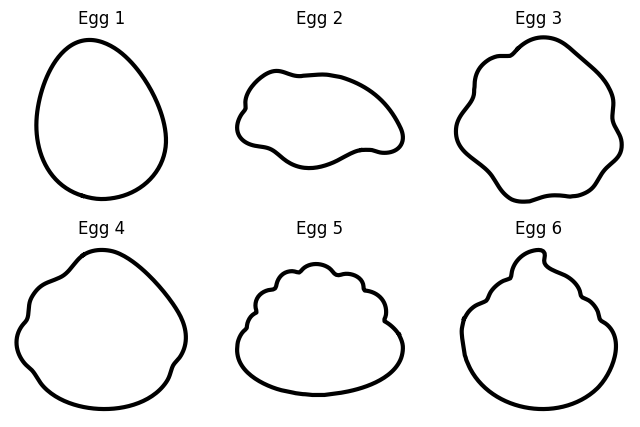

In [2]:
target_curves = np.load('target_curves.npy')

# Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')


## GA Full Mechanism Generation
To set up the problem within Pymoo we will have to come up with a 1D representation of the mechanisms. This code effectively just flattens the matrices and variables describing our mechanism into a single vector. However, this representation scheme is highly suboptimal, and can be improved significantly. As a demonstration, we will slightly improve upon this representation, though we encourage you to take this further. As we discussed, we can replace the edges with a connectivity matrrix. We also know the connectivity matrix is symmetric (if nodes 1 and 2 are connected nodes 2 and 1 are also connected) and has a diagonal equal to zero. To avoid making the optimization come up with the whole connectivity matrix, we will only have it come up with the upper triangular half of the matrix (not including the diagonal). This means the algorithm has to come up with $\frac{N^2-N}{2}$ 0s or 1s (i.e., booleans) to construct the adjacency matrix. We can further simplify the process by selecting a fixed motor position and having the optimization build the rest of the mechanism, removing the need for the optimization to determine the motor as well as reducing the number of 0s and 1s in the upper triangular portion by one (Saving 3 parameters in the representation). To do this we will start with the following mechanism:

<img src="https://i.ibb.co/mGywWgr/start.jpg" alt="start" border="0">

We set Node 0 to ground and Node 1 to be ordinary and the motor to be `[1,0]`. Now we know that the upper triangular portion of the connectivity matrix starts with:

<img src="https://i.ibb.co/5RqKYQN/upper-triangular-fromstart.jpg" alt="upper-triangular-fromstart" border="0">

Since we know the types of the first two nodes, we save another two parameters from the optimization. At this point we will have the same representation as we have before, but with fewer numbers and no motor or N (size of mechanisms) as we generate the mechanism to have a certain size.

<img src="https://i.ibb.co/gv2D0Y5/Optimization-Represenation.png" alt="Optimization-Represenation" border="0">

Now that we have a (slightly) improved 1D representation scheme, we will set up our problem with this many parameters. We also need to specify our constraints! Inequality constraints can be set in Pymoo (See: [constraints in pymoo](https://www.pymoo.org/constraints/index.html)) as less than or equal to zero constraints. We will set the two constraints on distance and material use in our problem.

So based on this lets get started with defining the problem in Pymoo.
<ul>
    <li>
        <code>__init__</code>: We need to differentiate between datatypes because crossover, sampling, and mutation will happen slightly differently based on datatype. As such, we create a dictionary of variables and specify which type of variable each one is.
    </li>
    <li>
<code>convert_1D_to_mech</code>: Reformats our dictionary of variables into design info that our simulator uses (edges, x0, etc.). You will need to update this function if you change the way you parameterize mechanisms. IMPORTANT: This function should not be confused for the. We have also provided a function, <code> convert_mech_to_1D </code> to do the opposite, which you may find useful. It is currently unused and is commented out.
    </li>
    <li>
<code>_evaluate</code>: Next, we define the evaluation function. We construct the mechanism using <code>convert_1D_to_mech</code>. Next, perform the same evaluations as we did in the starter notebook.
    </li>
</ul>

In [3]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling, Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

from LINKS.Optimization import DifferentiableTools, Tools

In [4]:
PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_curve, N = 5):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.target_curve = target_curve


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target joints index
        target_idx = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                # C[i,j] = x["C" + str(j) + "_" + str(i)]
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        edges = np.array(np.where(C==1)).T
        
        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_joints = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return x0, edges, fixed_joints, motor, target_idx

    def convert_mech_to_1D(self, x0, edges, fixed_joints, target_idx=None, **kwargs):
        # This function assumes motor to be [0, 1] our random mechanism generator automatically does this
        N = self.N

        # Initialize dictionary to store 1D representation of mechanism
        x = {}

        # Store target node value
        if target_idx is None:
            target_idx = x0.shape[0]-1 # Assume last node is the target if not specified
            
        x["target"] = target_idx

        # Store connectivity matrix in its flattened form
        C = np.zeros((N,N), dtype=bool)
        C[edges[:,0], edges[:,1]] = 1
        C[edges[:,1], edges[:,0]] = 1
       
        for i in range(N):
            for j in range(i):
                x["C" + str(j) + "_" + str(i)] = C[i,j]

        del x["C0_1"]
        
        # Store position matrix in its flattened form
        if x0.shape[0] != N:
            x0 = np.pad(x0, ((0, N - x0.shape[0]), (0, 0)), 'constant', constant_values=0)
            
        for i in range(2*N):
            x["X0" + str(i)] = x0.flatten()[i]

        # Store fixed nodes in boolean vector form
        for i in range(N):
            x["fixed_nodes" + str(i)] = (i in fixed_joints) or (i>=N)

        return x

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        x0, edges, fixed_joints, motor, target_idx = self.convert_1D_to_mech(x)
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                edges,
                                fixed_joints,
                                motor,
                                self.target_curve,
                                target_idx=target_idx
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0


Now let's try this with NSGA-II and one of the easier target curves. We will initialize with mechanisms with 6 nodes. You can test what happens if you increase this number. You should quickly discover that this naive parameterization does not perform well when initializing the GA with more complex mechanisms:

In [5]:
problem = mechanism_synthesis_optimization(target_curves[1], N=6)

algorithm = NSGA2(pop_size=100,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                #   mutation=PolynomialMutation(prob=0.9),
                  eliminate_duplicates=MixedVariableDuplicateElimination())

results = minimize(problem,
                algorithm,
                ('n_gen', 100),
                verbose=True,
                save_history=True,
                seed=0
                )

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  1.359641E+01 |           INF |             - |             -
     2 |      200 |      1 |  3.8797655106 |           INF |             - |             -
     3 |      300 |      1 |  3.8797655106 |           INF |             - |             -
     4 |      400 |      1 |  3.8797655106 |           INF |             - |             -
     5 |      500 |      1 |  3.8797655106 |           INF |             - |             -
     6 |      600 |      1 |  2.5941102505 |           INF |             - |             -
     7 |      700 |      1 |  2.5941102505 |           INF |             - |             -
     8 |      800 |      1 |  2.5941102505 |           INF |             - |             -
     9 |      900 |      1 |  0.8760614395 |           INF |             - |             -
    10 |     1000 |      1 |  0.8760614395 |           INF |             - |             -

In [6]:
if results.X is None:
    print("No feasible solution found !!!!!")

No feasible solution found !!!!!


You can see that if you just run GA you will not be able to find any good solutions, even for smaller mechanisms with 6 joints! 

In the starter notebook we gave you a mechanism to initialize GA with. Now we introduce the `MechanismRandomizer` class which can help you generate random mechanisms of any size you need. Let's see how this class works (The first time you run this it will be a little slow):

In [7]:
from LINKS.Optimization import MechanismRandomizer
from LINKS.Visualization import MechanismVisualizer

In [8]:
randomizer = MechanismRandomizer(
    min_size = 6, # smalllest mechanism to sample
    max_size = 14, # largest mechanism to sample
    device='cpu')

visualizer = MechanismVisualizer()

In [9]:
random_mechanism = randomizer()

# Let's see what the output looks like (it is exactly like the submission format)
print(random_mechanism)

{'x0': array([[0.00672208, 0.30434308],
       [0.09444426, 0.32314703],
       [0.71814523, 0.53270468],
       [0.46979491, 0.738745  ],
       [0.64405118, 0.82102564],
       [0.73955896, 0.36019162],
       [0.04767657, 0.5210782 ],
       [0.74297543, 0.66217877],
       [0.15670085, 0.94952192],
       [0.18760073, 0.15436882],
       [0.17956982, 0.24588698],
       [0.57262338, 0.83823424],
       [0.32943584, 0.88550956],
       [0.25987139, 0.72984461]]), 'edges': array([[ 0,  1],
       [ 1,  3],
       [ 2,  3],
       [ 3,  4],
       [ 2,  4],
       [ 1,  5],
       [ 4,  5],
       [ 4,  6],
       [ 5,  6],
       [ 1,  7],
       [ 2,  7],
       [ 6,  8],
       [ 5,  8],
       [ 3,  9],
       [ 4,  9],
       [ 7, 10],
       [ 8, 10],
       [ 9, 12],
       [11, 12],
       [12, 13],
       [10, 13]]), 'fixed_joints': array([ 0,  2, 11]), 'motor': array([0, 1])}


<Axes: >

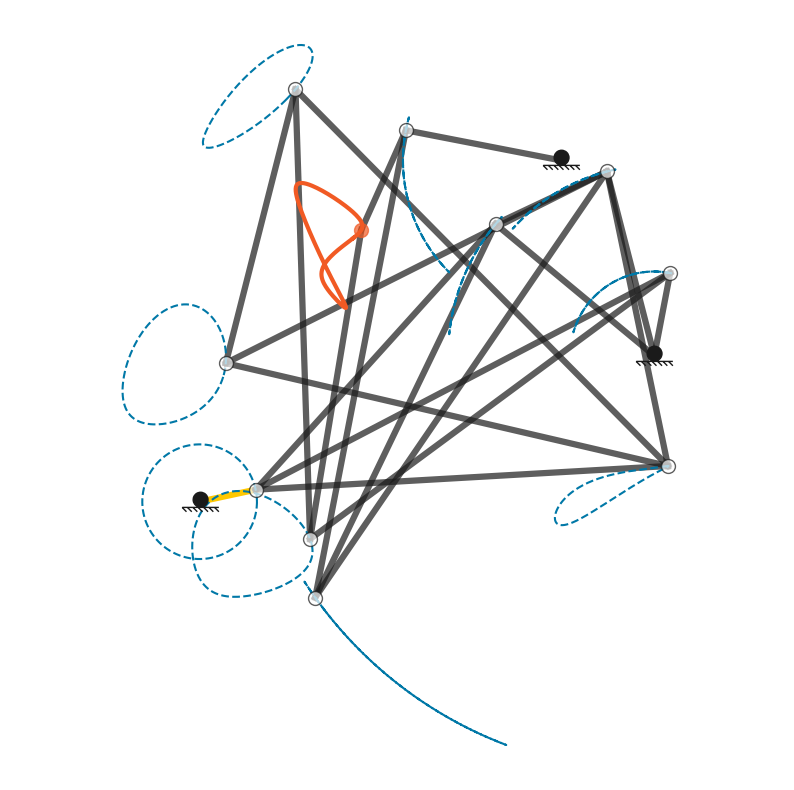

In [10]:
# Visualize the random mechanism
visualizer(**random_mechanism)

In [11]:
# Now let's generate 100 mechanisms of size 7 and initilize a population for optimization
mechanisms = [randomizer(n=7) for _ in trange(100)]

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
problem = mechanism_synthesis_optimization(target_curves[1], N=7)

initial_population = [problem.convert_mech_to_1D(**mech) for mech in mechanisms]

class sample_from_random(Sampling):
        def _do(self, problem, n_samples, **kwargs):
                return np.array([initial_population[i%len(initial_population)] for i in range(n_samples)])

F = problem.evaluate(np.array(initial_population))[0]
print(f'Best Distance Performance In random population: {F[:,0].min()}')
print(f'Best Material Performance In random population: {F[:,1].min()}')

Best Distance Performance In random population: 0.8713314533233643
Best Material Performance In random population: 4.422967433929443


In [13]:
algorithm = NSGA2(pop_size=100,
                  sampling=sample_from_random(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  mutation=PolynomialMutation(prob=0.5),
                  eliminate_duplicates=MixedVariableDuplicateElimination())

results = minimize(problem,
                algorithm,
                ('n_gen', 100),
                verbose=True,
                save_history=True,
                seed=123
                )

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.1213314533 |  8.2827894253 |             - |             -
     2 |      200 |      1 |  0.1213314533 |  7.2814367312 |             - |             -
     3 |      300 |      1 |  0.1213314533 |  6.2113751119 |             - |             -
     4 |      400 |      1 |  0.1213314533 |  5.5847412819 |             - |             -
     5 |      500 |      1 |  0.1213314533 |  5.3095588344 |             - |             -
     6 |      600 |      1 |  0.1213314533 |  4.8619539565 |             - |             -
     7 |      700 |      1 |  0.1213314533 |  4.4883618766 |             - |             -
     8 |      800 |      1 |  0.1213314533 |  4.1848054057 |             - |             -
     9 |      900 |      1 |  0.1213314533 |  3.7080964154 |             - |             -
    10 |     1000 |      1 |  0.1213314533 |  3.5503906387 |             - |             -

We see that if we initialize GA with some valid samples, it is much more likely to succeed! Let's take a look at the solutions of this run:

In [14]:
from LINKS.Visualization import GAVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Geometry import CurveEngine

Hyper Volume ~ 1.344672


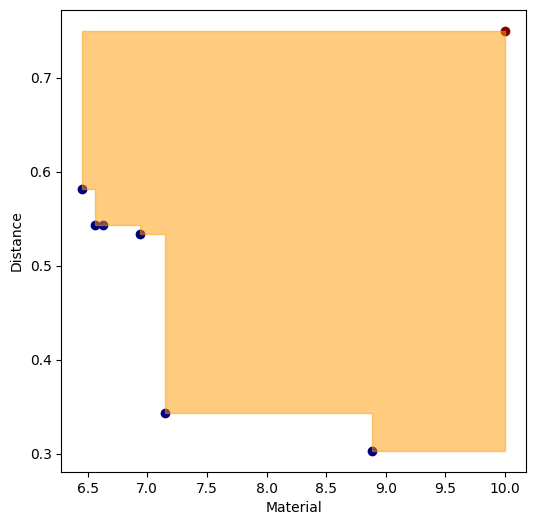

In [15]:
from pymoo.indicators.hv import HV
ga_visualizer = GAVisualizer()
solver = MechanismSolver(device='cpu')
curve_engine = CurveEngine(device='cpu')

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.75, 10.0])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    ga_visualizer.plot_HV(results.F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
else:
    print('Did Not Find Solutions!!')

Now Let's visualize the best solution for distance

In [16]:
if not results.X is None:
    if type(results.X)!=dict:
        best_idx = np.argmin(results.F[:,0])
        best_sol, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X[best_idx])
    else:
        best_sol, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X)
else:
    print('Did Not Find Solutions!!')

Distance: 0.3031, Material: 8.8832


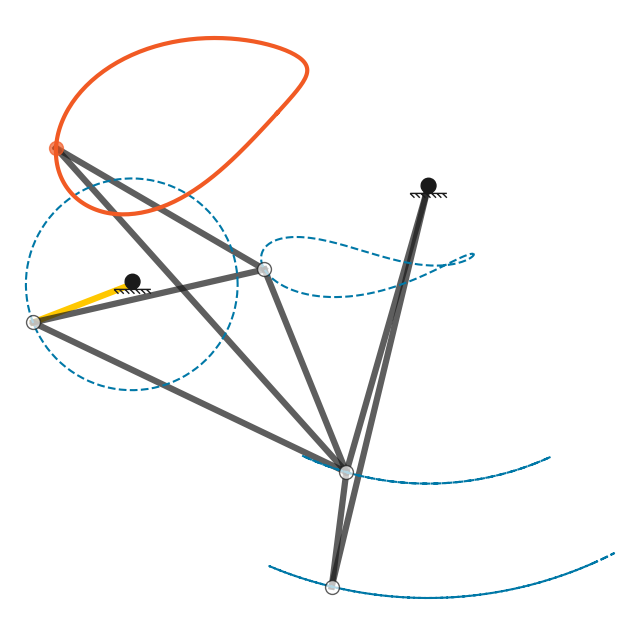

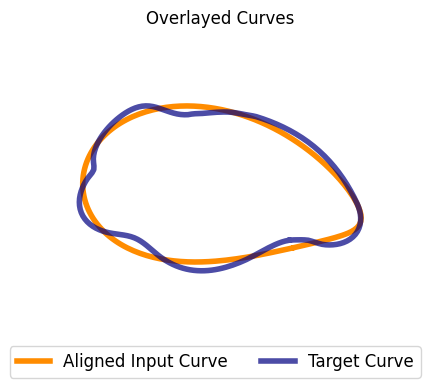

In [17]:
plt.figure(figsize=(8,8))
visualizer(best_sol, edges, fixed_joints, motor, highlight=target_idx, ax=plt.gca())

traced_curve = solver(best_sol, edges, fixed_joints, motor)[target_idx]
curve_engine.visualize_comparison(
    traced_curve,
    target_curves[1]
)

print(f'Distance: {results.F[best_idx,0]:.4f}, Material: {results.F[best_idx,1]:.4f}')

Now Let's visualize the best solution for material

In [18]:
if not results.X is None:
    if type(results.X)!=dict:
        best_idx = np.argmin(results.F[:,1])
        best_sol, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X[best_idx])
    else:
        best_sol, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X)
else:
    print('Did Not Find Solutions!!')

Distance: 0.5814, Material: 6.4564


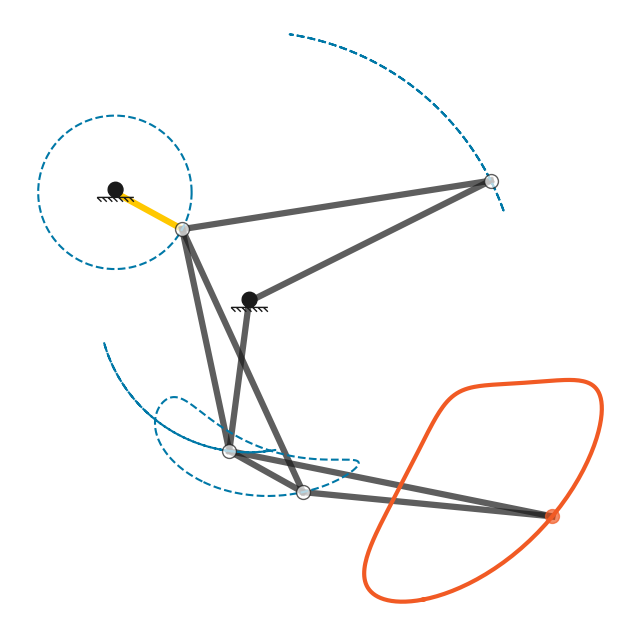

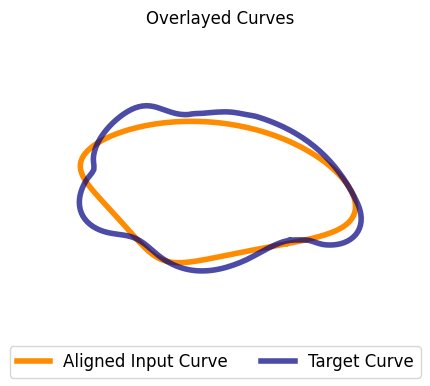

In [19]:
plt.figure(figsize=(8,8))
visualizer(best_sol, edges, fixed_joints, motor, ax=plt.gca())

traced_curve = solver(best_sol, edges, fixed_joints, motor)[target_idx]
curve_engine.visualize_comparison(
    traced_curve,
    target_curves[1]
)

print(f'Distance: {results.F[best_idx,0]:.4f}, Material: {results.F[best_idx,1]:.4f}')

You can use this population to make a submission:

In [20]:
from LINKS.CP import make_empty_submission, evaluate_submission

submission = make_empty_submission()

# add out population to submission
if not results.X is None:
    for i in range(results.X.shape[0]):
        if not isinstance(results.X, dict):
            x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X[i])
        else:
            x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X)
        
        mech = {
            'x0': x0_member,
            'edges': edges,
            'fixed_joints': fixed_joints,
            'motor': motor,
            'target_joint': target_idx
        }
        
        submission['Problem 2'].append(mech)

In [21]:
evaluate_submission(submission)

{'Overall Score': 0.2241121124419744,
 'Score Breakdown': {'Problem 1': 0.0,
  'Problem 2': 1.3446726746518465,
  'Problem 3': 0.0,
  'Problem 4': 0.0,
  'Problem 5': 0.0,
  'Problem 6': 0.0}}

You can see that GA is still not doing great with handling different mechanisms. You could adjust the initialization more, change mutation and cross-over functionality. So far however, we have not yet touched on gradient-based optimization. What if we took the solutions of GA and optimized for each of the objectives.

Now let's take the GA solutions from above and just optimize for the lowest distance. Then we will add the optimized solutions to the population we have and see how the hypervolume changes.

 **Note that if the material use exceeds 10 during this optimization the score will not change How could you address this?** 

In [22]:
from LINKS.Optimization import DifferentiableTools

In [23]:
differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs

In [24]:
# lets make a batch from our GA results
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if not results.X is None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member)
        edges.append(edges_member)
        fixed_joints.append(fixed_joints_member)
        motors.append(motor_member)
        target_idxs.append(target_idx_member)

here is how this differentiable class works:

In [25]:
distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s,
    edges,
    fixed_joints,
    motors,
    target_curves[1],
    target_idxs
)

print(materials, distances)

[8.8832035 6.560156  7.150685  6.63266   6.4563766 6.9418173] [0.30311337 0.54374576 0.34356877 0.5434047  0.5814006  0.53398204]


**NOTE:** Sometimes the mechanisms are close to locking, which results in gradients exploding and in these cases the `DifferentiableTools` will return inifity results. You can ignore these since the `Tools` class will still simulate them eventhough the gradients are near singular.

In [26]:
x = x0s.copy()

step_size = 4e-4
n_steps = 1000

# keep track of which members are done optimizing
done_optimizing = np.zeros(len(x), dtype=bool)

x_last = x.copy()

for step in trange(n_steps):
    
    # get current distances, materials and gradients
    distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
        x,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )
    
    # only update members that are valid and not done optimizing
    valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    
    # if a member is invalid, revert to last step and mark as done optimizing
    for i in invalids:
        done_optimizing[i] = True
        x[i] = x_last[i]
    
    # keep a copy of last step
    x_last = x.copy()
    
    # update valid members
    for i in valids:
        if done_optimizing[i]:
            continue
        x[i] = x[i] - step_size * distance_grads[i]
        
    if np.all(done_optimizing):
        print(f'All members are done optimizing at step {step}')
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

Now we can combine these new memebers with the old and see how the hypervolume changes:

In [27]:
combined_x0s = x0s + x
combined_edges = edges + edges
combined_fixed_joints = fixed_joints + fixed_joints
combined_motors = motors + motors
combined_target_idxs = target_idxs + target_idxs

F = np.array(
    PROBLEM_TOOLS(
        combined_x0s,
        combined_edges,
        combined_fixed_joints,
        combined_motors,
        target_curves[1],
        combined_target_idxs
    )).T

F_before = np.array(
    PROBLEM_TOOLS(
        x0s,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )).T

ref = np.array([0.75, 10.0])
ind = HV(ref)

hv_before = ind(F_before)
hv_after = ind(F)

print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization: {hv_after:.4f}')

Hypervolume before gradient optimization: 1.3447, after optimization: 1.5051


<Axes: title={'center': 'After Gradient Optimization'}, xlabel='Material', ylabel='Distance'>

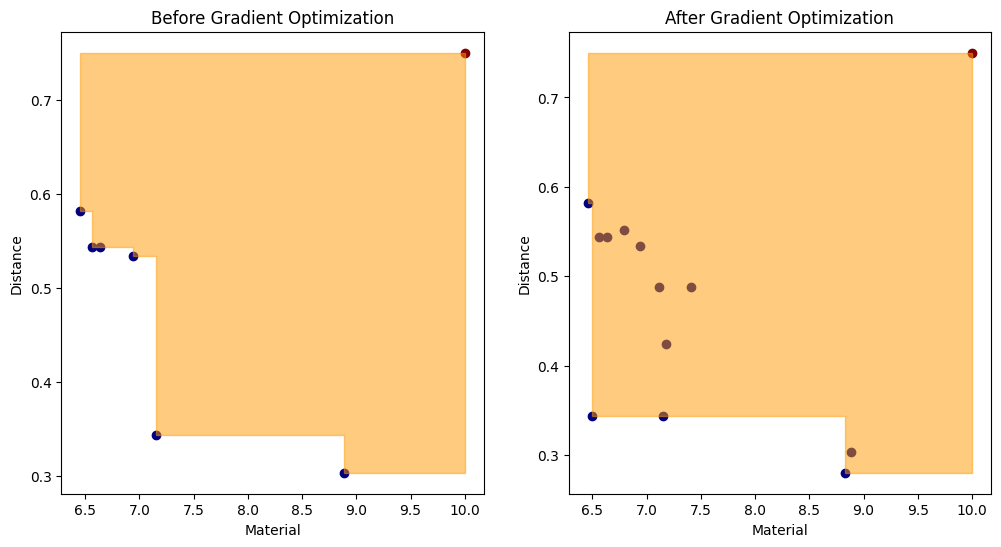

In [28]:
plt.subplots(1, 2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Before Gradient Optimization')
ga_visualizer.plot_HV(F_before, ref, objective_labels=['Distance', 'Material'], ax=plt.gca())

plt.subplot(1, 2, 2)
plt.title('After Gradient Optimization')
ga_visualizer.plot_HV(F, ref, objective_labels=['Distance', 'Material'], ax=plt.gca())

A small improvement. But this is just to give you an idea of what you can do when mixing optimization methods.

Now you should have a good idea of how to use the tools we have provided to you. Think about how you can improve each aspect of the optimization to achieve a higher score in you final submission. You are allowed also submit your teams best solutions to the leaderboard which we will announce soon and see how well you are doing compared other teams.

A few hints and ideas:
- Why not do some preprocessing to random mechanisms before running GA?
- Can you use the gradients of both functions in gradient based optimization? 
- Can you cycle through multiple optimization runs?
- Can you mix different kinds of GA? We showed how GA can be used for a single mechanism skeleton and how it can be used to also create the mechanisms?
- Can you modify the GA mutations and cross-over?
- Is there a more efficient representation of mechanisms we can use?
- Are there smarter gradient-based optimization methods?

# Appendix and Details

## Curve Distance Calculation

The target curves are provided to you as a sequence of points. The curves your mechanisms generate are then re-oriented compared to the target curves as we showed above. We measure the closeness of two point curves by computing the distance between the two curves with optimal alignment. This distance can be mathematically represented as:

$$
d_{OD}=\frac{2 \pi}{N}\min_{o_1 \in O_1, \alpha \in [0,2\pi)} \sum_{i=1}^N\left\|N(\mathbf{X}^{\text{coupler}}_{o_1(i)})\mathbf{R}(\alpha)-N(\mathbf{X}^{\text{target}})\right\|^2,
$$

$$\operatorname{N}(\mathbf{X})=\frac{\mathbf{X}- \overline{\mathbf{X}}}{\sqrt{\frac{\sum_{i=1}^N\|\mathbf{X}_i-\overline{\mathbf{X}}\|_2^2}{N}}}$$

Where $\mathbf{X}^{\text{coupler}}$ is the curve traced by the mechanism and $\mathbf{X}^{\text{target}}$ is the target curve and  $O_1$ is the set of all possible clockwise and counterclockwise orderings of a curve with $N$ ordered points and $\mathbf{R}(\alpha)$ is a $2\times2$ rotation matrix for angle $\alpha$, while $o_1(i)$ refers to the index of the $i$-th point in the set $o_1$. In practice, in our problem we may ignore the denominator in $N$ since we do not want to optimally rescale curves. The code we provide solves this optimization problem and retuns the distance value so you don't have to worry about this.

The other objective in this challenge problem is reducing the material used by the mechanism. This is the total length of all links in the mechanism. We have provided a function that makes this measurement for you using initial positions and adjacency matrix for a mechanism (The functions and useful tools are going to be described later).

### A Note On Scale Normalization

The functions that we saw in the starter notebool on curves, namely `compare_curves` and `visualize_comparison`, and `visualize_alignment` have a scaling option. An important input to the `CurveEngine` class is `normalize_scale`, which if set to `True` will rescale curves when comparing. In our problem we want this to be `False` since we care about the scale and material used in the problem. (We stress this distinction because the first component of the optimization demo had this rescaling turned on!)

In [29]:
curve_processor = CurveEngine(
    normalize_scale=True, # whether to normalize the curve's scale (This would mean we do not care about the size of the curve but we do!)
    device='cpu' # device to run the processing on
)

curve_processor_unscaled = CurveEngine(
    normalize_scale=False, # do not normalize the scale of the curve (This would mean we care about the size of the curve too!)
    device='cpu'
)

Let's go back to the simple fourbar we had and see what this means:

<Axes: >

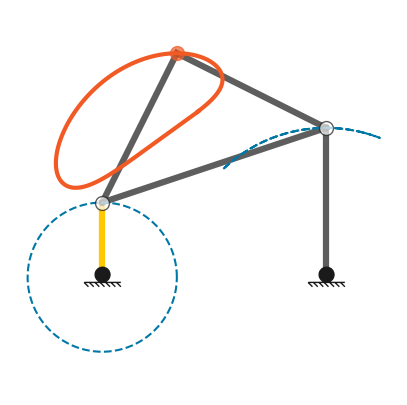

In [30]:
visualizer = MechanismVisualizer()

# Define the variables for the mechanism
x0 = np.array([[0.3,0.2],
               [0.6,0.2],
               [0.3,0.3],
               [0.6,0.4],
               [0.4,0.5]])

# Define the connectivity of the mechanism
edges = np.array([[0,2],
                  [1,3],
                  [2,3],
                  [2,4],
                  [3,4]])

# Define the fixed nodes
fixed_joints = np.array([0,1])

# actuator
motor = np.array([0,2])

plt.figure(figsize=(5,5))
visualizer(x0, edges, fixed_joints, motor, ax=plt.gca())

In [31]:
solver = MechanismSolver(
    device = 'cpu' # device to run the simulation on (cpu or gpu)
)

solution = solver(x0, edges, fixed_joints, motor)
traced_curve = solution[4]

In [32]:
# lets compare to the first target curve
distance = curve_processor.compare_curves(traced_curve, target_curves[0])
unscaled_distance = curve_processor_unscaled.compare_curves(traced_curve, target_curves[0])

print(f"The scale normalized distance to target curve 1 is: {distance:.4f}")
print(f"The unnormalized distance to target curve 1 is: {unscaled_distance:.4f}") # This will be higher since do not normalize scale

The scale normalized distance to target curve 1 is: 1.4590
The unnormalized distance to target curve 1 is: 3.3600


Now let's visualize the alignment process with and without scale to understand what is going on:

MITT FORSØK PÅ Å KOBLE SAMMEN

In [63]:
#prøv å koble sammen deres her
# Method 1)

from LINKS.Optimization import DifferentiableTools


differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs



# lets make a batch from our GA results
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if not results.X is None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member)
        edges.append(edges_member)
        fixed_joints.append(fixed_joints_member)
        motors.append(motor_member)
        target_idxs.append(target_idx_member)






distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s,
    edges,
    fixed_joints,
    motors,
    target_curves[1],
    target_idxs
)

print(materials, distances)





#Note: sometimes the mechanisms are close to locking, which results in gradients exploding and in these cases the DifferentiableTools will return infinity results
#You can ignore these since the Tools class will still simulate them eventhough the gradients are near singular


x = x0s.copy()

step_size = 4e-4
n_steps = 1000

# keep track of which members are done optimizing
done_optimizing = np.zeros(len(x), dtype=bool)

x_last = x.copy()

for step in trange(n_steps):
    
    # get current distances, materials and gradients
    distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
        x,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )
    
    # only update members that are valid and not done optimizing
    valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    
    # if a member is invalid, revert to last step and mark as done optimizing
    for i in invalids:
        done_optimizing[i] = True
        x[i] = x_last[i]
    
    # keep a copy of last step
    x_last = x.copy()
    
    # update valid members
    for i in valids:
        if done_optimizing[i]:
            continue
        if x[i].shape != distance_grads[i].shape:
            continue
        x[i] = x[i] - step_size * distance_grads[i]
        
    if np.all(done_optimizing):
        print(f'All members are done optimizing at step {step}')
        break

combined_x0s = x0s + x
combined_edges = edges + edges
combined_fixed_joints = fixed_joints + fixed_joints
combined_motors = motors + motors
combined_target_idxs = target_idxs + target_idxs

F = np.array(
    PROBLEM_TOOLS(
        combined_x0s,
        combined_edges,
        combined_fixed_joints,
        combined_motors,
        target_curves[1],
        combined_target_idxs
    )).T

F_before = np.array(
    PROBLEM_TOOLS(
        x0s,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )).T

ref = np.array([0.75, 10.0])
ind = HV(ref)

hv_before = ind(F_before)
hv_after = ind(F)

print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization: {hv_after:.4f}')

[8.8832035 6.560156  7.150685  6.63266   6.4563766 6.9418173] [0.30311337 0.54374576 0.34356877 0.5434047  0.5814006  0.53398204]


100%|██████████| 1000/1000 [00:08<00:00, 113.33it/s]

Hypervolume before gradient optimization: 1.3447, after optimization: 1.5051


In [ ]:
# Method 2)

from LINKS.Optimization import DifferentiableTools

differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs

# lets make a batch from our GA results
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if not results.X is None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member)
        edges.append(edges_member)
        fixed_joints.append(fixed_joints_member)
        motors.append(motor_member)
        target_idxs.append(target_idx_member)

distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s,
    edges,
    fixed_joints,
    motors,
    target_curves[1],
    target_idxs
)

print(materials, distances)

# Note: sometimes the mechanisms are close to locking, which results in gradients exploding
# and in these cases the DifferentiableTools will return infinity results

x = x0s.copy()

step_size = 4e-4
n_steps = 1000

# normalization caps for 50/50 weighting (also used later for normalized HV)
d_cap = 0.75
m_cap = 10.0

# keep track of which members are done optimizing
done_optimizing = np.zeros(len(x), dtype=bool)

x_last = x.copy()

for step in trange(n_steps):
    
    # get current distances, materials and gradients
    distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
        x,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )
    
    # only update members that are valid and not done optimizing
    valids = np.where(np.logical_and(distances <= d_cap, materials <= m_cap))[0]
    invalids = np.where(~np.logical_and(distances <= d_cap, materials <= m_cap))[0]
    
    # if a member is invalid, revert to last step and mark as done optimizing
    for i in invalids:
        done_optimizing[i] = True
        x[i] = x_last[i]
    
    # keep a copy of last step
    x_last = x.copy()
    
    # ===== 50/50 gradient on normalized objectives (distance + material) =====
    for i in valids:
        if done_optimizing[i]:
            continue
        # grad of 0.5*(d/d_cap) + 0.5*(m/m_cap)
        g = 0.5 * (distance_grads[i] / d_cap) + 0.5 * (material_grads[i] / m_cap)
        # simple clipped guard against NaNs/Infs
        if np.all(np.isfinite(g)):
            x[i] = x[i] - step_size * g
        
    if np.all(done_optimizing):
        print(f'All members are done optimizing at step {step}')
        break

combined_x0s = x0s + x
combined_edges = edges + edges
combined_fixed_joints = fixed_joints + fixed_joints
combined_motors = motors + motors
combined_target_idxs = target_idxs + target_idxs

F = np.array(
    PROBLEM_TOOLS(
        combined_x0s,
        combined_edges,
        combined_fixed_joints,
        combined_motors,
        target_curves[1],
        combined_target_idxs
    )).T

F_before = np.array(
    PROBLEM_TOOLS(
        x0s,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )).T

# original HV (unnormalized)
ref = np.array([d_cap, m_cap])
ind = HV(ref)

hv_before = ind(F_before)
hv_after = ind(F)
print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization: {hv_after:.4f}')

# ===== normalized HV (divide objectives by caps; ref becomes [1,1]) =====
F_before_norm = F_before / ref
F_norm = F / ref
ref_norm = np.array([1.0, 1.0])
ind_norm = HV(ref_norm)

hv_before_norm = ind_norm(F_before_norm)
hv_after_norm = ind_norm(F_norm)
print(f'Normalized HV before: {hv_before_norm:.4f}, after: {hv_after_norm:.4f}')


[8.8832035 6.560156  7.150685  6.63266   6.4563766 6.9418173] [0.30311337 0.54374576 0.34356877 0.5434047  0.5814006  0.53398204]


  0%|          | 0/1000 [00:00<?, ?it/s]

Hypervolume before gradient optimization: 1.3447, after optimization: 2.2696
Normalized HV before: 0.1793, after: 0.3026


In [ ]:
# Method 3)

import numpy as np
from tqdm import trange
from LINKS.Optimization import DifferentiableTools

differentiable_optimization_tools = DifferentiableTools(
    device='cpu'  # device to run the optimization on
)
differentiable_optimization_tools.compile()  # compile the functions for faster runs

# lets make a batch from our GA results
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if not results.X is None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
                problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
            problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member)
        edges.append(edges_member)
        fixed_joints.append(fixed_joints_member)
        motors.append(motor_member)
        target_idxs.append(target_idx_member)

# initial eval
distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s, edges, fixed_joints, motors, target_curves[1], target_idxs
)
print(materials, distances)

# ----- GRADIENT OPTIMIZATION (distance + material, adaptive + clipping + trust region) -----

# work copy
x = [xi.copy() for xi in x0s]

# normalization caps for 50/50 weighting
d_cap = 0.75
m_cap = 10.0

# adaptive LR per member (start from your old step size)
alpha = np.full(len(x), 4e-4, dtype=float)
grow, shrink = 1.2, 0.5
max_ls_tries = 5
feas_eps = 1e-3         # small tolerance on material feasibility

# stability
max_g_norm = 5.0        # clip gradient L2 norm (per member)
max_disp = 0.01         # cap max node displacement per step (trust region)

n_steps = 1000
done_optimizing = np.zeros(len(x), dtype=bool)

for step in trange(n_steps):
    # batch eval
    distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
        x, edges, fixed_joints, motors, target_curves[1], target_idxs
    )

    all_done = True
    for i in range(len(x)):
        if done_optimizing[i]:
            continue

        di = float(distances[i])
        mi = float(materials[i])
        gdi = distance_grads[i]      # (Ni,2)
        gmi = material_grads[i]      # (Ni,2)

        # skip if bad grads/vals
        if not (np.isfinite(di) and np.isfinite(mi) and
                np.all(np.isfinite(gdi)) and np.all(np.isfinite(gmi))):
            done_optimizing[i] = True
            continue

        # 50/50 scalarized objective (normalized)
        J0 = 0.5*(di/d_cap) + 0.5*(mi/m_cap)

        # gradient of the scalarized objective
        g = 0.5*(gdi/d_cap) + 0.5*(gmi/m_cap)

        # (no fixed-node freezing here)

        # gradient clipping
        gnorm = float(np.linalg.norm(g))
        if not np.isfinite(gnorm) or gnorm == 0.0:
            done_optimizing[i] = True
            continue
        if gnorm > max_g_norm:
            g = g * (max_g_norm / gnorm)

        # accept/reject with adaptive step size
        success = False
        a = float(alpha[i])
        for _ in range(max_ls_tries):
            x_try = x[i] - a * g

            # trust-region: cap displacement
            disp = float(np.linalg.norm(x_try - x[i]))
            if np.isfinite(disp) and disp > max_disp and disp > 0.0:
                x_try = x[i] + (max_disp/disp) * (x_try - x[i])

            # single-member eval for the trial
            d_try, m_try, gd_try, gm_try = differentiable_optimization_tools(
                [x_try], [edges[i]], [fixed_joints[i]], [motors[i]], target_curves[1], [target_idxs[i]]
            )
            d_try = float(d_try[0]); m_try = float(m_try[0])
            if not (np.isfinite(d_try) and np.isfinite(m_try)):
                a *= shrink
                continue

            J_try = 0.5*(d_try/d_cap) + 0.5*(m_try/m_cap)

            # accept if J improves and material stays ~feasible
            if (J_try < J0) and (m_try <= m_cap*(1.0 + feas_eps)):
                x[i] = x_try
                alpha[i] = a * grow   # grow lr on success
                success = True
                break
            else:
                a *= shrink           # shrink and retry

        if not success:
            done_optimizing[i] = True
        else:
            all_done = False

    if all_done:
        print(f"Stopped at step {step}: all members done.")
        break

# evaluation for hypervolume (union original + improved)
combined_x0s = x0s + x
combined_edges = edges + edges
combined_fixed_joints = fixed_joints + fixed_joints
combined_motors = motors + motors
combined_target_idxs = target_idxs + target_idxs

F = np.array(
    PROBLEM_TOOLS(
        combined_x0s,
        combined_edges,
        combined_fixed_joints,
        combined_motors,
        target_curves[1],
        combined_target_idxs
    )
).T

F_before = np.array(
    PROBLEM_TOOLS(
        x0s,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )
).T

ref = np.array([d_cap, m_cap])
ind = HV(ref)

hv_before = ind(F_before)
hv_after  = ind(F)
print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization: {hv_after:.4f}')



[8.8832035 6.560156  7.150685  6.63266   6.4563766 6.9418173] [0.30311337 0.54374576 0.34356877 0.5434047  0.5814006  0.53398204]


100%|██████████| 1000/1000 [00:22<00:00, 43.85it/s]

Hypervolume before gradient optimization: 1.3447, after optimization: 2.3901


In [ ]:
# method 4 and 5 and 6

import numpy as np
from LINKS.Optimization import DifferentiableTools
from scipy.optimize import minimize

# ----------------- kernel -----------------
differentiable_optimization_tools = DifferentiableTools(device='cpu')
differentiable_optimization_tools.compile()

# ----------------- build batch from GA -----------------
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if results.X is not None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = \
                problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = \
            problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member)
        edges.append(edges_member)
        fixed_joints.append(fixed_joints_member)
        motors.append(motor_member)
        target_idxs.append(target_idx_member)

# quick eval (sanity)
distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s, edges, fixed_joints, motors, target_curves[1], target_idxs
)
print(materials, distances)

# ----------------- L-BFGS-B per member (50/50 normalized) + tiny fallback -----------------
d_cap = 0.75
m_cap = 10.0

x = [xi.copy() for xi in x0s]

for i in range(len(x)):
    shape = x[i].shape

    # scalarized objective and gradient on flattened vector
    def obj(z):
        Xi = z.reshape(shape)
        d, m, gd, gm = differentiable_optimization_tools(
            [Xi], [edges[i]], [fixed_joints[i]], [motors[i]],
            target_curves[1], [target_idxs[i]]
        )
        d = float(d[0]);  m = float(m[0])
        if not (np.isfinite(d) and np.isfinite(m)):
            return 1e12, np.zeros_like(z)
        gd = gd[0]; gm = gm[0]  # (N,2)
        if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))):
            return 1e12, np.zeros_like(z)
        J  = 0.5*(d/d_cap) + 0.5*(m/m_cap)
        gJ = 0.5*(gd/d_cap) + 0.5*(gm/m_cap)  # (N,2)
        return J, gJ.reshape(-1)

    # J at the start
    d0, m0, gd0, gm0 = differentiable_optimization_tools(
        [x[i]], [edges[i]], [fixed_joints[i]], [motors[i]], target_curves[1], [target_idxs[i]]
    )
    J0 = 0.5*(float(d0[0])/d_cap) + 0.5*(float(m0[0])/m_cap)

    z0  = x[i].reshape(-1)
    res = minimize(
        obj, z0, method="BFGS", jac=True,
        options=dict(maxiter=150, ftol=1e-9, gtol=1e-7, maxcor=20, disp=False)
    )
    x_opt = res.x.reshape(shape)

    # evaluate result
    d1, m1, gd1, gm1 = differentiable_optimization_tools(
        [x_opt], [edges[i]], [fixed_joints[i]], [motors[i]], target_curves[1], [target_idxs[i]]
    )
    J1 = 0.5*(float(d1[0])/d_cap) + 0.5*(float(m1[0])/m_cap)

    # ---- tiny fallback if no improvement (nudges off flat starts) ----
    if not np.isfinite(J1) or (J1 >= J0 - 1e-12):
        # do up to 10 tiny backtracking GD steps on J
        Xi = x[i].copy()
        alpha0 = 1e-2    # base step
        for t in range(10):
            d, m, gd, gm = differentiable_optimization_tools(
                [Xi], [edges[i]], [fixed_joints[i]], [motors[i]], target_curves[1], [target_idxs[i]]
            )
            d = float(d[0]); m = float(m[0])
            if not (np.isfinite(d) and np.isfinite(m)): break
            gd = gd[0]; gm = gm[0]
            if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))): break
            J  = 0.5*(d/d_cap) + 0.5*(m/m_cap)
            gJ = 0.5*(gd/d_cap) + 0.5*(gm/m_cap)
            gnorm = float(np.linalg.norm(gJ))
            if not np.isfinite(gnorm) or gnorm == 0.0: break
            a = alpha0 / (1e-8 + gnorm)  # scale by grad magnitude
            # backtracking
            ok = False
            for _ in range(5):
                Xtry = Xi - a * gJ
                d2, m2, gd2, gm2 = differentiable_optimization_tools(
                    [Xtry], [edges[i]], [fixed_joints[i]], [motors[i]], target_curves[1], [target_idxs[i]]
                )
                d2 = float(d2[0]); m2 = float(m2[0])
                if not (np.isfinite(d2) and np.isfinite(m2)):
                    a *= 0.5; continue
                J2 = 0.5*(d2/d_cap) + 0.5*(m2/m_cap)
                if J2 < J - 1e-4*a*gnorm*gnorm:
                    Xi = Xtry; ok = True; break
                a *= 0.5
            if not ok: break
        x[i] = Xi
    else:
        x[i] = x_opt

# ----------------- hypervolume (union: before + after) -----------------
combined_x0s = x0s + x
combined_edges = edges + edges
combined_fixed_joints = fixed_joints + fixed_joints
combined_motors = motors + motors
combined_target_idxs = target_idxs + target_idxs

F = np.array(
    PROBLEM_TOOLS(
        combined_x0s,
        combined_edges,
        combined_fixed_joints,
        combined_motors,
        target_curves[1],
        combined_target_idxs
    )
).T

F_before = np.array(
    PROBLEM_TOOLS(
        x0s,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )
).T

ref = np.array([d_cap, m_cap])
ind = HV(ref)

hv_before = ind(F_before)
hv_after  = ind(F)
print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization: {hv_after:.4f}')



[8.8832035 6.560156  7.150685  6.63266   6.4563766 6.9418173] [0.30311337 0.54374576 0.34356877 0.5434047  0.5814006  0.53398204]


/var/folders/yv/mg_7_p1x7jndyms2rfyvrmsr0000gn/T/ipykernel_64015/2874171962.py:75: OptimizeWarning: Unknown solver options: ftol, maxcor
  res = minimize(
/Users/louiseronglan/VScode/CP1/Gradient-descent/.venv/lib/python3.10/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast
  if stp > self.stpmax:
/Users/louiseronglan/VScode/CP1/Gradient-descent/.venv/lib/python3.10/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/Users/louiseronglan/VScode/CP1/Gradient-descent/.venv/lib/python3.10/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/Users/louiseronglan/VScode/CP1/Gradient-descent/.venv/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:403: RuntimeWarning: overflow encountered in cast
  alpha1 = min(alpha1, amax)
/Users/louiseronglan/VScode/CP1/Grad

Hypervolume before gradient optimization: 1.3447, after optimization: 3.1747


In [ ]:
#method 7

import numpy as np
import warnings
from scipy.optimize import minimize, OptimizeWarning
from LINKS.Optimization import DifferentiableTools

# Silence OptimizeWarning lines in the output (e.g., from unknown options)
warnings.filterwarnings("ignore", category=OptimizeWarning)

# ----------------- kernel -----------------
differentiable_optimization_tools = DifferentiableTools(device='cpu')
differentiable_optimization_tools.compile()

# ----------------- build batch from GA -----------------
x0s, edges, fixed_joints, motors, target_idxs = [], [], [], [], []
if results.X is not None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
                problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member); edges.append(edges_member)
            fixed_joints.append(fixed_joints_member); motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
            problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member); edges.append(edges_member)
        fixed_joints.append(fixed_joints_member); motors.append(motor_member)
        target_idxs.append(target_idx_member)

# quick eval (sanity)
distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s, edges, fixed_joints, motors, target_curves[1], target_idxs
)
print("materials:", materials)
print("distances:", distances)

# ----------------- config -----------------
d_cap, m_cap = 0.75, 10.0
weights = [(0.90,0.10),(0.75,0.25),(0.60,0.40),(0.50,0.50),(0.40,0.60),(0.25,0.75),(0.10,0.90)]

# HV before (originals only)
F_before = np.array(
    PROBLEM_TOOLS(x0s, edges, fixed_joints, motors, target_curves[1], target_idxs)
).T
ref = np.array([d_cap, m_cap])
ind = HV(ref)
hv_before = ind(F_before)
print(f"HV before: {hv_before:.4f}")

hv_results = []

# ----------------- sweep weights -----------------
for (wd, wm) in weights:
    print(f"\n=== Optimizing with weights (wd, wm) = ({wd:.2f}, {wm:.2f}) ===")
    x = [xi.copy() for xi in x0s]  # working copy for this weight

    for i in range(len(x)):
        shape = x[i].shape

        # scalarized objective and gradient on flattened vector (weight-specific)
        def obj(z):
            Xi = z.reshape(shape)
            d, m, gd, gm = differentiable_optimization_tools(
                [Xi], [edges[i]], [fixed_joints[i]], [motors[i]],
                target_curves[1], [target_idxs[i]]
            )
            d = float(d[0]); m = float(m[0])
            if not (np.isfinite(d) and np.isfinite(m)):
                return 1e12, np.zeros_like(z)
            gd = gd[0]; gm = gm[0]
            if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))):
                return 1e12, np.zeros_like(z)
            J  = wd*(d/d_cap) + wm*(m/m_cap)
            gJ = wd*(gd/d_cap) + wm*(gm/m_cap)
            return J, gJ.reshape(-1)

        # J at the start (for this member)
        d0, m0, gd0, gm0 = differentiable_optimization_tools(
            [x[i]],[edges[i]],[fixed_joints[i]],[motors[i]], target_curves[1],[target_idxs[i]]
        )
        J0 = wd*(float(d0[0])/d_cap) + wm*(float(m0[0])/m_cap)

        z0 = x[i].reshape(-1)
        # BFGS options (no 'ftol' here; it's not a valid BFGS option)
        res = minimize(
            obj, z0,
            method="BFGS", jac=True,
            options=dict(maxiter=200, gtol=1e-5, disp=False)
        )
        x_opt = res.x.reshape(shape)

        # evaluate result
        d1, m1, gd1, gm1 = differentiable_optimization_tools(
            [x_opt],[edges[i]],[fixed_joints[i]],[motors[i]], target_curves[1],[target_idxs[i]]
        )
        J1 = wd*(float(d1[0])/d_cap) + wm*(float(m1[0])/m_cap)

        # ---- tiny fallback if no improvement (nudges off flat starts) ----
        if not np.isfinite(J1) or (J1 >= J0 - 1e-12):
            Xi = x[i].copy()
            alpha0 = 1e-2    # base step
            for t in range(10):
                d, m, gd, gm = differentiable_optimization_tools(
                    [Xi],[edges[i]],[fixed_joints[i]],[motors[i]], target_curves[1],[target_idxs[i]]
                )
                d = float(d[0]); m = float(m[0])
                if not (np.isfinite(d) and np.isfinite(m)): break
                gd = gd[0]; gm = gm[0]
                if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))): break
                J  = wd*(d/d_cap) + wm*(m/m_cap)
                gJ = wd*(gd/d_cap) + wm*(gm/m_cap)
                gnorm = float(np.linalg.norm(gJ))
                if not np.isfinite(gnorm) or gnorm == 0.0: break
                a = alpha0 / (1e-8 + gnorm)
                # backtracking
                ok = False
                for _ in range(5):
                    Xtry = Xi - a * gJ
                    d2, m2, gd2, gm2 = differentiable_optimization_tools(
                        [Xtry],[edges[i]],[fixed_joints[i]],[motors[i]], target_curves[1],[target_idxs[i]]
                    )
                    d2 = float(d2[0]); m2 = float(m2[0])
                    if not (np.isfinite(d2) and np.isfinite(m2)):
                        a *= 0.5; continue
                    J2 = wd*(d2/d_cap) + wm*(m2/m_cap)
                    if J2 < J - 1e-4*a*gnorm*gnorm:
                        Xi = Xtry; ok = True; break
                    a *= 0.5
                if not ok: break
            x[i] = Xi
        else:
            x[i] = x_opt

    # HV on union (original + this weight's optimized set)
    combined_x0s = x0s + x
    combined_edges = edges + edges
    combined_fixed_joints = fixed_joints + fixed_joints
    combined_motors = motors + motors
    combined_target_idxs = target_idxs + target_idxs

    F = np.array(
        PROBLEM_TOOLS(
            combined_x0s, combined_edges, combined_fixed_joints, combined_motors,
            target_curves[1], combined_target_idxs
        )
    ).T

    hv_after = ind(F)
    hv_results.append(((wd, wm), hv_after, x))
    print(f"HV with weights ({wd:.2f}, {wm:.2f}): {hv_after:.4f}  (Δ {hv_after - hv_before:+.4f})")

# ----------------- pick the best weight -----------------
hv_results.sort(key=lambda t: t[1], reverse=True)
(best_w, best_hv, best_x) = hv_results[0]
print(f"\nBest weights: (wd, wm) = ({best_w[0]:.2f}, {best_w[1]:.2f})  "
      f"HV = {best_hv:.4f}  (Δ {best_hv - hv_before:+.4f})")

# Optionally keep the best optimized designs:
# x = best_x


materials: [8.8832035 6.560156  7.150685  6.63266   6.4563766 6.9418173]
distances: [0.30311337 0.54374576 0.34356877 0.5434047  0.5814006  0.53398204]
HV before: 1.3447

=== Optimizing with weights (wd, wm) = (0.90, 0.10) ===
HV with weights (0.90, 0.10): 3.1548  (Δ +1.8102)

=== Optimizing with weights (wd, wm) = (0.75, 0.25) ===
HV with weights (0.75, 0.25): 3.2138  (Δ +1.8691)

=== Optimizing with weights (wd, wm) = (0.60, 0.40) ===
HV with weights (0.60, 0.40): 3.2619  (Δ +1.9173)

=== Optimizing with weights (wd, wm) = (0.50, 0.50) ===
HV with weights (0.50, 0.50): 3.2716  (Δ +1.9270)

=== Optimizing with weights (wd, wm) = (0.40, 0.60) ===
HV with weights (0.40, 0.60): 3.2446  (Δ +1.8999)

=== Optimizing with weights (wd, wm) = (0.25, 0.75) ===
HV with weights (0.25, 0.75): 3.0352  (Δ +1.6905)

=== Optimizing with weights (wd, wm) = (0.10, 0.90) ===
HV with weights (0.10, 0.90): 3.1444  (Δ +1.7998)

Best weights: (wd, wm) = (0.50, 0.50)  HV = 3.2716  (Δ +1.9270)


In [ ]:
# method 8 — Newton-CG version

import numpy as np
from LINKS.Optimization import DifferentiableTools
from scipy.optimize import minimize

# ----------------- kernel -----------------
differentiable_optimization_tools = DifferentiableTools(device='cpu')
differentiable_optimization_tools.compile()

# ----------------- build batch from GA -----------------
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if results.X is not None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
                problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member); edges.append(edges_member)
            fixed_joints.append(fixed_joints_member); motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
            problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member); edges.append(edges_member)
        fixed_joints.append(fixed_joints_member); motors.append(motor_member)
        target_idxs.append(target_idx_member)

# quick eval (sanity)
distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s, edges, fixed_joints, motors, target_curves[1], target_idxs
)
print(materials, distances)

# ----------------- Newton-CG per member (50/50 normalized) + tiny fallback -----------------
d_cap = 0.75
m_cap = 10.0

x = [xi.copy() for xi in x0s]

for i in range(len(x)):
    shape = x[i].shape

    # evaluate scalarized J and gradient at Xi (gradient returned flattened)
    def eval_J_g(Xi):
        d, m, gd, gm = differentiable_optimization_tools(
            [Xi], [edges[i]], [fixed_joints[i]], [motors[i]],
            target_curves[1], [target_idxs[i]]
        )
        d = float(d[0]);  m = float(m[0])
        if not (np.isfinite(d) and np.isfinite(m)):
            return 1e12, None
        gd = gd[0]; gm = gm[0]
        if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))):
            return 1e12, None
        J  = 0.5*(d/d_cap) + 0.5*(m/m_cap)
        gJ = 0.5*(gd/d_cap) + 0.5*(gm/m_cap)   # (N,2)
        return J, gJ.reshape(-1)

    # objective (J and grad) for SciPy
    def obj(z):
        Xi = z.reshape(shape)
        J, g = eval_J_g(Xi)
        if g is None:
            return 1e12, np.zeros_like(z)
        return J, g

    # Hessian-vector product via finite diff of grad: H·p ≈ (g(X+εp) - g(X))/ε
    def hessp(z, p):
        Xi = z.reshape(shape)
        P  = p.reshape(shape)
        # scale epsilon relative to p
        pnorm = float(np.linalg.norm(p)) + 1e-12
        eps = 1e-4 / pnorm
        _, g0 = obj(z)
        J1, g1 = eval_J_g(Xi + eps * P)
        if g1 is None:
            # if failed, return a small multiple of p (damped)
            return 1e-2 * p
        return (g1 - g0) / eps

    # J at the start
    J0, _g0 = eval_J_g(x[i])

    z0  = x[i].reshape(-1)
    res = minimize(
        fun=lambda z: obj(z)[0],
        x0=z0,
        jac=lambda z: obj(z)[1],
        hessp=hessp,
        method="Newton-CG",
        options=dict(maxiter=150, xtol=1e-5, disp=False)
    )
    x_opt = res.x.reshape(shape)

    # evaluate result
    J1, _ = eval_J_g(x_opt)

    # ---- tiny fallback if no improvement (nudges off flat starts) ----
    if not np.isfinite(J1) or (J1 >= J0 - 1e-12):
        Xi = x[i].copy()
        alpha0 = 1e-2    # base step
        for t in range(10):
            J, g = eval_J_g(Xi)
            if g is None: break
            gnorm = float(np.linalg.norm(g))
            if not np.isfinite(gnorm) or gnorm == 0.0: break
            a = alpha0 / (1e-8 + gnorm)
            ok = False
            for _ in range(5):
                Xtry = Xi - a * g.reshape(shape)
                J2, _g2 = eval_J_g(Xtry)
                if np.isfinite(J2) and (J2 < J - 1e-4*a*gnorm*gnorm):
                    Xi = Xtry; ok = True; break
                a *= 0.5
            if not ok: break
        x[i] = Xi
    else:
        x[i] = x_opt

# ----------------- hypervolume (union: before + after) -----------------
combined_x0s = x0s + x
combined_edges = edges + edges
combined_fixed_joints = fixed_joints + fixed_joints
combined_motors = motors + motors
combined_target_idxs = target_idxs + target_idxs

F = np.array(
    PROBLEM_TOOLS(
        combined_x0s,
        combined_edges,
        combined_fixed_joints,
        combined_motors,
        target_curves[1],
        combined_target_idxs
    )
).T

F_before = np.array(
    PROBLEM_TOOLS(
        x0s,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )
).T

ref = np.array([d_cap, m_cap])
ind = HV(ref)

hv_before = ind(F_before)
hv_after  = ind(F)
print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization: {hv_after:.4f}')


[8.8832035 6.560156  7.150685  6.63266   6.4563766 6.9418173] [0.30311337 0.54374576 0.34356877 0.5434047  0.5814006  0.53398204]
Hypervolume before gradient optimization: 1.3447, after optimization: 3.2021


In [ ]:
# method 9 — ADAM version

import numpy as np
from LINKS.Optimization import DifferentiableTools

# ----------------- kernel -----------------
differentiable_optimization_tools = DifferentiableTools(device='cpu')
differentiable_optimization_tools.compile()

# ----------------- build batch from GA -----------------
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if results.X is not None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
                problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member); edges.append(edges_member)
            fixed_joints.append(fixed_joints_member); motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
            problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member); edges.append(edges_member)
        fixed_joints.append(fixed_joints_member); motors.append(motor_member)
        target_idxs.append(target_idx_member)

# quick eval (sanity)
distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s, edges, fixed_joints, motors, target_curves[1], target_idxs
)
print(materials, distances)

# ----------------- ADAM per member (50/50 normalized) -----------------
d_cap = 0.75
m_cap = 10.0

# Adam hyperparameters
lr      = 2e-3      # step size
beta1   = 0.9
beta2   = 0.999
eps     = 1e-8
n_steps = 600
max_g_norm = 5.0    # simple gradient-norm clip (stability)
patience = 30       # early-stop if no J improvement
improve_tol = 1e-8

x = [xi.copy() for xi in x0s]

for i in range(len(x)):
    shape = x[i].shape
    m1 = np.zeros(shape, dtype=float)  # first moment
    m2 = np.zeros(shape, dtype=float)  # second moment

    # evaluate start
    d0, m0, gd0, gm0 = differentiable_optimization_tools(
        [x[i]], [edges[i]], [fixed_joints[i]], [motors[i]], target_curves[1], [target_idxs[i]]
    )
    Jbest = 0.5*(float(d0[0])/d_cap) + 0.5*(float(m0[0])/m_cap)
    Xbest = x[i].copy()
    stale = 0

    t = 0
    for step in range(1, n_steps+1):
        # objective + grads
        d, m, gd, gm = differentiable_optimization_tools(
            [x[i]], [edges[i]], [fixed_joints[i]], [motors[i]], target_curves[1], [target_idxs[i]]
        )
        d = float(d[0]); m = float(m[0])
        if not (np.isfinite(d) and np.isfinite(m)):
            break
        gd = gd[0]; gm = gm[0]
        if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))):
            break

        J  = 0.5*(d/d_cap) + 0.5*(m/m_cap)
        g  = 0.5*(gd/d_cap) + 0.5*(gm/m_cap)    # (N,2)

        # gradient-norm clipping
        gnorm = float(np.linalg.norm(g))
        if not np.isfinite(gnorm) or gnorm == 0.0:
            break
        if gnorm > max_g_norm:
            g = g * (max_g_norm / gnorm)

        # Adam update (bias-corrected)
        t += 1
        m1 = beta1*m1 + (1-beta1)*g
        m2 = beta2*m2 + (1-beta2)*(g*g)
        m1_hat = m1 / (1 - beta1**t)
        m2_hat = m2 / (1 - beta2**t)
        step_vec = lr * m1_hat / (np.sqrt(m2_hat) + eps)

        x[i] = x[i] - step_vec

        # keep best and early stop
        if J < Jbest - improve_tol:
            Jbest = J
            Xbest = x[i].copy()
            stale = 0
        else:
            stale += 1
            if stale >= patience:
                break

    # restore best iterate found
    x[i] = Xbest

# ----------------- hypervolume (union: before + after) -----------------
combined_x0s = x0s + x
combined_edges = edges + edges
combined_fixed_joints = fixed_joints + fixed_joints
combined_motors = motors + motors
combined_target_idxs = target_idxs + target_idxs

F = np.array(
    PROBLEM_TOOLS(
        combined_x0s,
        combined_edges,
        combined_fixed_joints,
        combined_motors,
        target_curves[1],
        combined_target_idxs
    )
).T

F_before = np.array(
    PROBLEM_TOOLS(
        x0s,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )
).T

ref = np.array([d_cap, m_cap])
ind = HV(ref)

hv_before = ind(F_before)
hv_after  = ind(F)
print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization: {hv_after:.4f}')


[8.8832035 6.560156  7.150685  6.63266   6.4563766 6.9418173] [0.30311337 0.54374576 0.34356877 0.5434047  0.5814006  0.53398204]
Hypervolume before gradient optimization: 1.3447, after optimization: 3.2622


In [57]:
# BFGS vs ADAM across ALL target curves
# Uses per-target reference so HV_before is meaningful on every curve

import numpy as np
import warnings
from scipy.optimize import minimize, OptimizeWarning
from LINKS.Optimization import DifferentiableTools

warnings.filterwarnings("ignore", category=OptimizeWarning)

# ----------------- kernel -----------------
differentiable_optimization_tools = DifferentiableTools(device='cpu')
differentiable_optimization_tools.compile()

# ----------------- build batch from GA -----------------
x0s, edges, fixed_joints, motors, target_idxs = [], [], [], [], []
if results.X is not None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
                problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member); edges.append(edges_member)
            fixed_joints.append(fixed_joints_member); motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
            problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member); edges.append(edges_member)
        fixed_joints.append(fixed_joints_member); motors.append(motor_member)
        target_idxs.append(target_idx_member)

# quick sanity (target 0)
distances, materials, *_ = differentiable_optimization_tools(
    x0s, edges, fixed_joints, motors, target_curves[0], target_idxs
)
print("materials (target 0):", materials)
print("distances  (target 0):", distances)

# ----------------- common config -----------------
d_cap, m_cap = 0.75, 10.0                 # used in the scalarized objective
ref_default = np.array([d_cap, m_cap])    # preferred ref; may be relaxed per target
ind_default = HV(ref_default)

# ADAM hyperparameters
adam_lr = 2e-3; adam_beta1 = 0.9; adam_beta2 = 0.999
adam_eps = 1e-8; adam_steps = 600; adam_clip = 5.0
adam_patience = 30; adam_improve_tol = 1e-8

# ----------------- helpers -----------------
def _finite_rows(F):
    mask = np.all(np.isfinite(F), axis=1)
    return F[mask]

def _repeat_to_len(lst, L):
    if len(lst) == 0: return lst
    reps = int(np.ceil(L / len(lst)))
    return (lst * reps)[:L]

def _F_for_designs(designs, target_k):
    L = len(designs)
    E  = _repeat_to_len(edges,        L)
    FJ = _repeat_to_len(fixed_joints, L)
    M  = _repeat_to_len(motors,       L)
    TI = _repeat_to_len(target_idxs,  L)
    return np.array(PROBLEM_TOOLS(designs, E, FJ, M, target_curves[target_k], TI)).T

def _per_target_ref(F_before, F_after):
    """Pick a fair per-target reference. If default produces HV_before=0,
    expand ref to slightly dominate the union by 5% (but not below default)."""
    Fb = _finite_rows(F_before)
    Fa = _finite_rows(F_after)
    if Fb.size == 0:
        return ref_default.copy(), 0.0, 0.0
    hv_bef = ind_default(Fb)
    if hv_bef > 0:
        return ref_default.copy(), hv_bef, ind_default(Fa) if Fa.size else 0.0
    # fallback ref
    F_union = Fb if Fa.size == 0 else np.vstack([Fb, Fa])
    ref_fb = np.maximum(np.max(F_union, axis=0) * 1.05, ref_default)
    ind_fb = HV(ref_fb)
    return ref_fb, ind_fb(Fb), ind_fb(Fa) if Fa.size else 0.0

# ----------------- sweep over all target curves -----------------
summary = []
gain_bfgs_list, gain_adam_list = [], []

for k in range(len(target_curves)):
    print(f"\n=== Target {k} ===")

    # ---------- HV 'before' (per-target ref) ----------
    F_before = _F_for_designs(x0s, k)

    # ---------- BFGS optimization ----------
    x_bfgs = [xi.copy() for xi in x0s]
    for i in range(len(x_bfgs)):
        shape = x_bfgs[i].shape

        def obj(z):
            Xi = z.reshape(shape)
            d, m, gd, gm = differentiable_optimization_tools(
                [Xi], [edges[i]], [fixed_joints[i]], [motors[i]],
                target_curves[k], [target_idxs[i]]
            )
            d = float(d[0]); m = float(m[0])
            if not (np.isfinite(d) and np.isfinite(m)): return 1e12, np.zeros_like(z)
            gd = gd[0]; gm = gm[0]
            if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))): return 1e12, np.zeros_like(z)
            J  = 0.5*(d/d_cap) + 0.5*(m/m_cap)
            gJ = 0.5*(gd/d_cap) + 0.5*(gm/m_cap)
            return J, gJ.reshape(-1)

        d0, m0, *_ = differentiable_optimization_tools(
            [x_bfgs[i]], [edges[i]], [fixed_joints[i]], [motors[i]],
            target_curves[k], [target_idxs[i]]
        )
        J0 = 0.5*(float(d0[0])/d_cap) + 0.5*(float(m0[0])/m_cap)

        z0 = x_bfgs[i].reshape(-1)
        res = minimize(obj, z0, method="BFGS", jac=True,
                       options=dict(maxiter=200, gtol=1e-5, disp=False))
        x_opt = res.x.reshape(shape)

        d1, m1, *_ = differentiable_optimization_tools(
            [x_opt], [edges[i]], [fixed_joints[i]], [motors[i]],
            target_curves[k], [target_idxs[i]]
        )
        J1 = 0.5*(float(d1[0])/d_cap) + 0.5*(float(m1[0])/m_cap)
        if not np.isfinite(J1) or (J1 >= J0 - 1e-12):
            # tiny backtracking fallback
            Xi = x_bfgs[i].copy(); alpha0 = 1e-2
            for _ in range(10):
                d, m, gd, gm = differentiable_optimization_tools(
                    [Xi], [edges[i]], [fixed_joints[i]], [motors[i]],
                    target_curves[k], [target_idxs[i]]
                )
                d = float(d[0]); m = float(m[0])
                if not (np.isfinite(d) and np.isfinite(m)): break
                gd = gd[0]; gm = gm[0]
                if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))): break
                J  = 0.5*(d/d_cap) + 0.5*(m/m_cap)
                gJ = 0.5*(gd/d_cap) + 0.5*(gm/m_cap)
                gnorm = float(np.linalg.norm(gJ))
                if not np.isfinite(gnorm) or gnorm == 0.0: break
                a = alpha0 / (1e-8 + gnorm)
                ok = False
                for __ in range(5):
                    Xtry = Xi - a * gJ
                    d2, m2, gd2, gm2 = differentiable_optimization_tools(
                        [Xtry], [edges[i]], [fixed_joints[i]], [motors[i]],
                        target_curves[k], [target_idxs[i]]
                    )
                    d2 = float(d2[0]); m2 = float(m2[0])
                    if not (np.isfinite(d2) and np.isfinite(m2)): a *= 0.5; continue
                    J2 = 0.5*(d2/d_cap) + 0.5*(m2/m_cap)
                    if J2 < J - 1e-4*a*gnorm*gnorm: Xi = Xtry; ok = True; break
                    a *= 0.5
                if not ok: break
            x_bfgs[i] = Xi
        else:
            x_bfgs[i] = x_opt

    F_bfgs_union = _F_for_designs(x0s + x_bfgs, k)

    # ---------- ADAM optimization ----------
    x_adam = [xi.copy() for xi in x0s]
    for i in range(len(x_adam)):
        shape = x_adam[i].shape
        m1 = np.zeros(shape); m2 = np.zeros(shape)
        d0, m0, *_ = differentiable_optimization_tools(
            [x_adam[i]], [edges[i]], [fixed_joints[i]], [motors[i]],
            target_curves[k], [target_idxs[i]]
        )
        Jbest = 0.5*(float(d0[0])/d_cap) + 0.5*(float(m0[0])/m_cap)
        Xbest = x_adam[i].copy(); stale = 0; t = 0

        for step in range(1, adam_steps+1):
            d, m, gd, gm = differentiable_optimization_tools(
                [x_adam[i]], [edges[i]], [fixed_joints[i]], [motors[i]],
                target_curves[k], [target_idxs[i]]
            )
            d = float(d[0]); m = float(m[0])
            if not (np.isfinite(d) and np.isfinite(m)): break
            gd = gd[0]; gm = gm[0]
            if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))): break

            J = 0.5*(d/d_cap) + 0.5*(m/m_cap)
            g = 0.5*(gd/d_cap) + 0.5*(gm/m_cap)

            gnorm = float(np.linalg.norm(g))
            if not np.isfinite(gnorm) or gnorm == 0.0: break
            if gnorm > adam_clip: g *= (adam_clip / gnorm)

            t += 1
            m1 = adam_beta1*m1 + (1-adam_beta1)*g
            m2 = adam_beta2*m2 + (1-adam_beta2)*(g*g)
            m1_hat = m1 / (1 - adam_beta1**t)
            m2_hat = m2 / (1 - adam_beta2**t)
            step_vec = adam_lr * m1_hat / (np.sqrt(m2_hat) + adam_eps)
            x_adam[i] = x_adam[i] - step_vec

            if J < Jbest - adam_improve_tol:
                Jbest = J; Xbest = x_adam[i].copy(); stale = 0
            else:
                stale += 1
                if stale >= adam_patience: break

        x_adam[i] = Xbest

    F_adam_union = _F_for_designs(x0s + x_adam, k)

    # ---------- HV using per-target ref (so HV_before never "mysteriously zero") ----------
    ref_used, hv_bef, hv_bfgs = None, None, None
    ref_used, hv_bef, hv_bfgs = _per_target_ref(F_before, F_bfgs_union)
    _,        _,      hv_adam = _per_target_ref(F_before, F_adam_union)

    print(f"ref used: [{ref_used[0]:.4f}, {ref_used[1]:.4f}]")
    print(f"HV_before={hv_bef:.4f} | BFGS={hv_bfgs:.4f} (Δ {hv_bfgs - hv_bef:+.4f}) | "
          f"ADAM={hv_adam:.4f} (Δ {hv_adam - hv_bef:+.4f})")

    gain_bfgs_list.append(hv_bfgs - hv_bef)
    gain_adam_list.append(hv_adam - hv_bef)
    summary.append((k, hv_bef, hv_bfgs, hv_adam, ref_used))

# ----------------- summary & averages -----------------
print("\n=== Summary across all targets ===")
for (k, hv_b, hv_bfgs, hv_adam, ref_used) in summary:
    print(f"Target {k}: ref=[{ref_used[0]:.4f}, {ref_used[1]:.4f}] | "
          f"HV_before={hv_b:.4f} | BFGS={hv_bfgs:.4f} (Δ {hv_bfgs - hv_b:+.4f}) | "
          f"ADAM={hv_adam:.4f} (Δ {hv_adam - hv_b:+.4f})")

if gain_bfgs_list:
    print(f"\nAverage HV increase — BFGS: {np.mean(gain_bfgs_list):.4f} | "
          f"ADAM: {np.mean(gain_adam_list):.4f}")





materials (target 0): [8.8832035 6.560156  7.150685  6.63266   6.4563766 6.9418173]
distances  (target 0): [0.8959207 1.3451353 1.007737  1.2794061 1.1235149 1.2688829]

=== Target 0 ===
ref used: [1.4124, 10.0000]
HV_before=1.4784 | BFGS=8.3419 (Δ +6.8634) | ADAM=5.0976 (Δ +3.6191)

=== Target 1 ===
ref used: [0.7500, 10.0000]
HV_before=1.3447 | BFGS=3.2716 (Δ +1.9270) | ADAM=3.2622 (Δ +1.9175)

=== Target 2 ===
ref used: [1.9146, 10.0000]
HV_before=1.5833 | BFGS=10.7880 (Δ +9.2047) | ADAM=6.4378 (Δ +4.8545)

=== Target 3 ===
ref used: [1.8963, 10.0000]
HV_before=1.6002 | BFGS=10.4262 (Δ +8.8260) | ADAM=7.7294 (Δ +6.1292)

=== Target 4 ===
ref used: [1.4690, 10.0000]
HV_before=1.4414 | BFGS=8.4737 (Δ +7.0323) | ADAM=5.1522 (Δ +3.7108)

=== Target 5 ===
ref used: [1.8345, 10.0000]
HV_before=1.5776 | BFGS=11.2250 (Δ +9.6474) | ADAM=8.1339 (Δ +6.5563)

=== Summary across all targets ===
Target 0: ref=[1.4124, 10.0000] | HV_before=1.4784 | BFGS=8.3419 (Δ +6.8634) | ADAM=5.0976 (Δ +3.6191)

In [ ]:
# method 11 - tuning of BFGS

import numpy as np
from LINKS.Optimization import DifferentiableTools
from scipy.optimize import minimize

# ----------------- kernel -----------------
differentiable_optimization_tools = DifferentiableTools(device='cpu')
differentiable_optimization_tools.compile()

# ----------------- build batch from GA -----------------
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if results.X is not None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = \
                problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = \
            problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member)
        edges.append(edges_member)
        fixed_joints.append(fixed_joints_member)
        motors.append(motor_member)
        target_idxs.append(target_idx_member)

# quick eval (sanity)
distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s, edges, fixed_joints, motors, target_curves[1], target_idxs
)
print(materials, distances)

# ----------------- L-BFGS-B per member (50/50 normalized) + tiny fallback -----------------
d_cap = 0.75
m_cap = 10.0

x = [xi.copy() for xi in x0s]

for i in range(len(x)):
    shape = x[i].shape

    # scalarized objective and gradient on flattened vector
    def obj(z):
        Xi = z.reshape(shape)
        d, m, gd, gm = differentiable_optimization_tools(
            [Xi], [edges[i]], [fixed_joints[i]], [motors[i]],
            target_curves[1], [target_idxs[i]]
        )
        d = float(d[0]);  m = float(m[0])
        if not (np.isfinite(d) and np.isfinite(m)):
            return 1e12, np.zeros_like(z)
        gd = gd[0]; gm = gm[0]  # (N,2)
        if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))):
            return 1e12, np.zeros_like(z)
        J  = 0.5*(d/d_cap) + 0.5*(m/m_cap)
        gJ = 0.5*(gd/d_cap) + 0.5*(gm/m_cap)  # (N,2)
        return J, gJ.reshape(-1)

    # J at the start
    d0, m0, gd0, gm0 = differentiable_optimization_tools(
        [x[i]], [edges[i]], [fixed_joints[i]], [motors[i]], target_curves[1], [target_idxs[i]]
    )
    J0 = 0.5*(float(d0[0])/d_cap) + 0.5*(float(m0[0])/m_cap)

    z0  = x[i].reshape(-1)
    res = minimize(
        obj, z0, method="BFGS", jac=True,
        options=dict(maxiter=150, ftol=1e-9, gtol=1e-7, maxcor=20, disp=False)
    )
    x_opt = res.x.reshape(shape)

    # evaluate result
    d1, m1, gd1, gm1 = differentiable_optimization_tools(
        [x_opt], [edges[i]], [fixed_joints[i]], [motors[i]], target_curves[1], [target_idxs[i]]
    )
    J1 = 0.5*(float(d1[0])/d_cap) + 0.5*(float(m1[0])/m_cap)

    # ---- tiny fallback if no improvement (nudges off flat starts) ----
    if not np.isfinite(J1) or (J1 >= J0 - 1e-12):
        # do up to 10 tiny backtracking GD steps on J
        Xi = x[i].copy()
        alpha0 = 1e-2    # base step
        for t in range(10):
            d, m, gd, gm = differentiable_optimization_tools(
                [Xi], [edges[i]], [fixed_joints[i]], [motors[i]], target_curves[1], [target_idxs[i]]
            )
            d = float(d[0]); m = float(m[0])
            if not (np.isfinite(d) and np.isfinite(m)): break
            gd = gd[0]; gm = gm[0]
            if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))): break
            J  = 0.5*(d/d_cap) + 0.5*(m/m_cap)
            gJ = 0.5*(gd/d_cap) + 0.5*(gm/m_cap)
            gnorm = float(np.linalg.norm(gJ))
            if not np.isfinite(gnorm) or gnorm == 0.0: break
            a = alpha0 / (1e-8 + gnorm)  # scale by grad magnitude
            # backtracking
            ok = False
            for _ in range(5):
                Xtry = Xi - a * gJ
                d2, m2, gd2, gm2 = differentiable_optimization_tools(
                    [Xtry], [edges[i]], [fixed_joints[i]], [motors[i]], target_curves[1], [target_idxs[i]]
                )
                d2 = float(d2[0]); m2 = float(m2[0])
                if not (np.isfinite(d2) and np.isfinite(m2)):
                    a *= 0.5; continue
                J2 = 0.5*(d2/d_cap) + 0.5*(m2/m_cap)
                if J2 < J - 1e-4*a*gnorm*gnorm:
                    Xi = Xtry; ok = True; break
                a *= 0.5
            if not ok: break
        x[i] = Xi
    else:
        x[i] = x_opt

# ----------------- hypervolume (union: before + after) -----------------
combined_x0s = x0s + x
combined_edges = edges + edges
combined_fixed_joints = fixed_joints + fixed_joints
combined_motors = motors + motors
combined_target_idxs = target_idxs + target_idxs

F = np.array(
    PROBLEM_TOOLS(
        combined_x0s,
        combined_edges,
        combined_fixed_joints,
        combined_motors,
        target_curves[1],
        combined_target_idxs
    )
).T

F_before = np.array(
    PROBLEM_TOOLS(
        x0s,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )
).T

ref = np.array([d_cap, m_cap])
ind = HV(ref)

hv_before = ind(F_before)
hv_after  = ind(F)
print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization: {hv_after:.4f}')


In [58]:
# === Improved per-member optimizer: Adam warm-start + restarts + continuation + soft-constraint ===
import numpy as np
from LINKS.Optimization import DifferentiableTools
from scipy.optimize import minimize

# ----------------- kernel -----------------
differentiable_optimization_tools = DifferentiableTools(device='cpu')
differentiable_optimization_tools.compile()

# ----------------- build batch from GA -----------------
x0s, edges, fixed_joints, motors, target_idxs = [], [], [], [], []
if results.X is not None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
                problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member); edges.append(edges_member)
            fixed_joints.append(fixed_joints_member); motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
            problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member); edges.append(edges_member)
        fixed_joints.append(fixed_joints_member); motors.append(motor_member)
        target_idxs.append(target_idx_member)

# quick eval (sanity) on your favorite target (1 here)
TARGET_K = 1
distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s, edges, fixed_joints, motors, target_curves[TARGET_K], target_idxs
)
print("materials:", materials)
print("distances:", distances)

# ----------------- settings -----------------
# scalarization weights to try; union of all runs used for HV
weight_sets = [(0.5, 0.5), (0.7, 0.3), (0.3, 0.7)]

# distance cap continuation (easy -> hard)
d_cap_stages = [2.0, 1.2, 0.9, 0.75]
m_cap = 10.0

# Adam warm-start
adam_lr, adam_b1, adam_b2, adam_eps = 2e-3, 0.9, 0.999, 1e-8
adam_steps, grad_clip = 200, 5.0

# BFGS
bfgs_opts = dict(maxiter=200, gtol=1e-5, disp=False)

# tiny GD fallback (if BFGS fails to improve)
fb_alpha0 = 1e-2
fb_max_outer, fb_bt = 10, 5

# augmented-Lagrangian penalty for material (soft constraint)
al_lambda, al_rho = 0.0, 5.0   # increase rho if many results exceed m_cap

# ----------------- helpers -----------------
def hv_for(designs):
    return np.array(
        PROBLEM_TOOLS(
            designs,
            edges * (len(designs) // len(x0s)),
            fixed_joints * (len(designs) // len(x0s)),
            motors * (len(designs) // len(x0s)),
            target_curves[TARGET_K],
            target_idxs * (len(designs) // len(x0s)),
        )
    ).T

def obj_builder(i, wd, wm, d_cap):
    """Return (fun) that maps z(flat) -> (J, grad_flat) with AL on material."""
    shape = x[i].shape
    def obj(z):
        Xi = z.reshape(shape)
        d, m, gd, gm = differentiable_optimization_tools(
            [Xi], [edges[i]], [fixed_joints[i]], [motors[i]],
            target_curves[TARGET_K], [target_idxs[i]]
        )
        d = float(d[0]); m = float(m[0])
        if not (np.isfinite(d) and np.isfinite(m)):
            return 1e12, np.zeros_like(z)
        gd = gd[0]; gm = gm[0]
        if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))):
            return 1e12, np.zeros_like(z)

        d_norm = d / d_cap
        m_norm = m / m_cap
        J_base = wd*d_norm + wm*m_norm
        if m_norm <= 1.0:
            J  = J_base
            gJ = wd*(gd/d_cap) + wm*(gm/m_cap)
        else:
            vio = m_norm - 1.0
            J  = J_base + al_lambda*vio + 0.5*al_rho*(vio**2)
            gJ = wd*(gd/d_cap) + (wm + al_lambda + al_rho*vio)*(gm/m_cap)

        return float(J), gJ.reshape(-1)
    return obj

# ----------------- optimize for each weight set -----------------
all_runs = []   # list[list[designs]]; each inner list is one weight-set result

for (wd, wm) in weight_sets:
    print(f"\n=== Optimize with weights (wd, wm) = ({wd:.2f}, {wm:.2f}) ===")
    x = [xi.copy() for xi in x0s]  # start from GA results for this run

    for d_cap in d_cap_stages:
        print(f"  - stage d_cap={d_cap}")
        for i in range(len(x)):
            shape = x[i].shape
            obj = obj_builder(i, wd, wm, d_cap)

            # ---------- Adam warm-start ----------
            z = x[i].reshape(-1).copy()
            m1 = np.zeros_like(z); m2 = np.zeros_like(z)
            for t in range(1, adam_steps+1):
                J, g = obj(z)
                if not np.isfinite(J) or not np.all(np.isfinite(g)): break
                # clip gradient
                gnorm = float(np.linalg.norm(g))
                if gnorm > 0 and gnorm > grad_clip:
                    g = g * (grad_clip / gnorm)
                # adam update
                m1 = adam_b1*m1 + (1-adam_b1)*g
                m2 = adam_b2*m2 + (1-adam_b2)*(g*g)
                m1h = m1 / (1 - adam_b1**t)
                m2h = m2 / (1 - adam_b2**t)
                step = adam_lr * m1h / (np.sqrt(m2h) + adam_eps)
                z -= step

            # ---------- BFGS with two light restarts ----------
            starts = [
                z,
                z + 0.01*np.random.randn(*z.shape),
                z - 0.01*np.random.randn(*z.shape),
            ]
            bestJ, bestz = None, None
            for z0_try in starts:
                res = minimize(obj, z0_try, method="BFGS", jac=True, options=bfgs_opts)
                J_try, _ = obj(res.x)
                if bestJ is None or (np.isfinite(J_try) and J_try < bestJ):
                    bestJ, bestz = J_try, res.x

            x_opt = bestz.reshape(shape)

            # ---------- tiny fallback if needed ----------
            d0, m0, *_ = differentiable_optimization_tools(
                [x[i]], [edges[i]], [fixed_joints[i]], [motors[i]],
                target_curves[TARGET_K], [target_idxs[i]]
            )
            J0 = 0.5*(float(d0[0])/d_cap) + 0.5*(float(m0[0])/m_cap)
            d1, m1v, *_ = differentiable_optimization_tools(
                [x_opt], [edges[i]], [fixed_joints[i]], [motors[i]],
                target_curves[TARGET_K], [target_idxs[i]]
            )
            J1 = 0.5*(float(d1[0])/d_cap) + 0.5*(float(m1v[0])/m_cap)

            if not np.isfinite(J1) or (J1 >= J0 - 1e-12):
                Xi = x[i].copy()
                for _ in range(fb_max_outer):
                    J, g = obj(Xi.reshape(-1))
                    if not np.isfinite(J) or not np.all(np.isfinite(g)): break
                    gnorm = float(np.linalg.norm(g))
                    if gnorm == 0 or not np.isfinite(gnorm): break
                    a = fb_alpha0 / (1e-8 + gnorm)
                    ok = False
                    for __ in range(fb_bt):
                        Xtry = Xi.reshape(-1) - a * g
                        J2, _ = obj(Xtry)
                        if np.isfinite(J2) and J2 < J - 1e-4*a*gnorm*gnorm:
                            Xi = Xtry.reshape(shape); ok = True; break
                        a *= 0.5
                    if not ok: break
                x[i] = Xi
            else:
                x[i] = x_opt

    all_runs.append([xi.copy() for xi in x])

# ----------------- HV: before vs union(after) -----------------
# reference for HV is the final (hardest) caps
ref = np.array([d_cap_stages[-1], m_cap])
ind = HV(ref)

F_before = np.array(
    PROBLEM_TOOLS(
        x0s, edges, fixed_joints, motors, target_curves[TARGET_K], target_idxs
    )
).T

# Flatten all runs and build replicated metadata lists to match length
runs_flat = sum(all_runs, [])                      # concatenate lists of members
rep = 1 + len(all_runs)
combined_x0s = x0s + runs_flat
combined_edges = edges * rep
combined_fixed_joints = fixed_joints * rep
combined_motors = motors * rep
combined_target_idxs = target_idxs * rep

F_after = np.array(
    PROBLEM_TOOLS(
        combined_x0s,
        combined_edges,
        combined_fixed_joints,
        combined_motors,
        target_curves[TARGET_K],
        combined_target_idxs
    )
).T

hv_before = ind(F_before)
hv_after  = ind(F_after)
print(f"\nHypervolume before: {hv_before:.4f}  |  after (union): {hv_after:.4f}  |  Δ = {hv_after-hv_before:+.4f}")


materials: [8.8832035 6.560156  7.150685  6.63266   6.4563766 6.9418173]
distances: [0.30311337 0.54374576 0.34356877 0.5434047  0.5814006  0.53398204]

=== Optimize with weights (wd, wm) = (0.50, 0.50) ===
  - stage d_cap=2.0
  - stage d_cap=1.2
  - stage d_cap=0.9
  - stage d_cap=0.75

=== Optimize with weights (wd, wm) = (0.70, 0.30) ===
  - stage d_cap=2.0
  - stage d_cap=1.2
  - stage d_cap=0.9
  - stage d_cap=0.75

=== Optimize with weights (wd, wm) = (0.30, 0.70) ===
  - stage d_cap=2.0
  - stage d_cap=1.2
  - stage d_cap=0.9
  - stage d_cap=0.75

Hypervolume before: 1.3447  |  after (union): 3.4278  |  Δ = +2.0832


In [59]:
# === BFGS-only: multi-start + continuation + soft material penalty + tiny GD fallback ===
import numpy as np
from LINKS.Optimization import DifferentiableTools
from scipy.optimize import minimize

np.random.seed(0)  # reproducibility for the small jitters

# ----------------- kernel -----------------
differentiable_optimization_tools = DifferentiableTools(device='cpu')
differentiable_optimization_tools.compile()

# ----------------- build batch from GA -----------------
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if results.X is not None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
                problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = \
            problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member)
        edges.append(edges_member)
        fixed_joints.append(fixed_joints_member)
        motors.append(motor_member)
        target_idxs.append(target_idx_member)

# ----------------- quick sanity on chosen target -----------------
TARGET_K = 1  # same target as your original script
distances, materials, *_ = differentiable_optimization_tools(
    x0s, edges, fixed_joints, motors, target_curves[TARGET_K], target_idxs
)
print("materials:", materials)
print("distances:", distances)

# ----------------- settings -----------------
# distance cap continuation (easy -> hard), and fixed material cap
d_cap_stages = [2.0, 1.2, 0.9, 0.75]
m_cap        = 10.0

# try a small weight sweep; union of all runs will be used for HV
weight_sets  = [(0.5, 0.5), (0.7, 0.3), (0.3, 0.7)]

# BFGS solver options (valid for 'BFGS')
bfgs_opts    = dict(maxiter=300, gtol=1e-6, disp=False)

# multi-start jitters (very small)
jitter_sigma = 1e-2

# tiny GD fallback if BFGS doesn’t improve J
fb_alpha0    = 1e-2
fb_outer     = 10
fb_backtracks= 5

# augmented-Lagrangian penalty parameters for material soft constraint
al_lambda    = 0.0
al_rho       = 5.0  # raise (e.g., 10, 20) if many finals exceed m_cap

# ----------------- objective builder (per member, weight, and current d_cap) -----------------
def make_obj(i, wd, wm, d_cap):
    shape = x[i].shape
    def obj(z):
        Xi = z.reshape(shape)
        d, m, gd, gm = differentiable_optimization_tools(
            [Xi], [edges[i]], [fixed_joints[i]], [motors[i]],
            target_curves[TARGET_K], [target_idxs[i]]
        )
        d = float(d[0]); m = float(m[0])
        if not (np.isfinite(d) and np.isfinite(m)):
            return 1e12, np.zeros_like(z)
        gd = gd[0]; gm = gm[0]
        if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))):
            return 1e12, np.zeros_like(z)

        d_norm = d / d_cap
        m_norm = m / m_cap

        # base scalarization
        J_base = wd*d_norm + wm*m_norm

        # soft penalty only when material exceeds cap
        if m_norm <= 1.0:
            J  = J_base
            gJ = wd*(gd/d_cap) + wm*(gm/m_cap)
        else:
            vio = m_norm - 1.0
            J  = J_base + al_lambda*vio + 0.5*al_rho*(vio**2)
            gJ = wd*(gd/d_cap) + (wm + al_lambda + al_rho*vio)*(gm/m_cap)

        return float(J), gJ.reshape(-1)
    return obj

# ----------------- optimization across weights & continuation stages -----------------
all_runs = []  # store final designs for each weight (after all stages)

for (wd, wm) in weight_sets:
    print(f"\n=== Optimize with weights (wd, wm) = ({wd:.2f}, {wm:.2f}) ===")
    x = [xi.copy() for xi in x0s]  # start this weight run from GA results

    # solve easy problems first, then tighten d_cap
    for d_cap in d_cap_stages:
        print(f"  - stage d_cap={d_cap}")
        for i in range(len(x)):
            shape = x[i].shape
            obj = make_obj(i, wd, wm, d_cap)

            # starting value & J for fallback comparison
            d0, m0, *_ = differentiable_optimization_tools(
                [x[i]], [edges[i]], [fixed_joints[i]], [motors[i]],
                target_curves[TARGET_K], [target_idxs[i]]
            )
            J0 = 0.5*(float(d0[0])/d_cap) + 0.5*(float(m0[0])/m_cap)

            # -------- multi-start BFGS (base + two small jitters) --------
            z_base = x[i].reshape(-1)
            starts = [
                z_base,
                z_base + jitter_sigma*np.random.randn(*z_base.shape),
                z_base - jitter_sigma*np.random.randn(*z_base.shape),
            ]

            bestJ, bestz = None, None
            for z0_try in starts:
                res = minimize(obj, z0_try, method="BFGS", jac=True, options=bfgs_opts)
                J_try, _ = obj(res.x)
                if bestJ is None or (np.isfinite(J_try) and J_try < bestJ):
                    bestJ, bestz = J_try, res.x

            x_opt = bestz.reshape(shape)

            # -------- tiny GD fallback if no improvement --------
            d1, m1v, *_ = differentiable_optimization_tools(
                [x_opt], [edges[i]], [fixed_joints[i]], [motors[i]],
                target_curves[TARGET_K], [target_idxs[i]]
            )
            J1 = 0.5*(float(d1[0])/d_cap) + 0.5*(float(m1v[0])/m_cap)

            if (not np.isfinite(J1)) or (J1 >= J0 - 1e-12):
                Xi = x[i].copy()
                for _ in range(fb_outer):
                    J, g = obj(Xi.reshape(-1))
                    if not np.isfinite(J) or not np.all(np.isfinite(g)): break
                    gnorm = float(np.linalg.norm(g))
                    if gnorm == 0.0 or not np.isfinite(gnorm): break
                    a = fb_alpha0 / (1e-8 + gnorm)
                    ok = False
                    for __ in range(fb_backtracks):
                        Xtry = Xi.reshape(-1) - a * g
                        J2, _ = obj(Xtry)
                        if np.isfinite(J2) and (J2 < J - 1e-4*a*gnorm*gnorm):
                            Xi = Xtry.reshape(shape); ok = True; break
                        a *= 0.5
                    if not ok: break
                x[i] = Xi
            else:
                x[i] = x_opt

    all_runs.append([xi.copy() for xi in x])

# ----------------- hypervolume (originals vs union of all runs) -----------------
ref = np.array([d_cap_stages[-1], m_cap])  # final (hardest) caps
ind = HV(ref)

F_before = np.array(
    PROBLEM_TOOLS(
        x0s, edges, fixed_joints, motors, target_curves[TARGET_K], target_idxs
    )
).T

# flatten the runs and replicate metadata to match length
runs_flat = sum(all_runs, [])
rep = 1 + len(all_runs)  # originals + one set per weight
combined_x0s          = x0s + runs_flat
combined_edges        = edges * rep
combined_fixed_joints = fixed_joints * rep
combined_motors       = motors * rep
combined_target_idxs  = target_idxs * rep

F_after = np.array(
    PROBLEM_TOOLS(
        combined_x0s,
        combined_edges,
        combined_fixed_joints,
        combined_motors,
        target_curves[TARGET_K],
        combined_target_idxs
    )
).T

hv_before = ind(F_before)
hv_after  = ind(F_after)
print(f"\nHypervolume before: {hv_before:.4f}  |  after (union): {hv_after:.4f}  |  Δ = {hv_after - hv_before:+.4f}")


materials: [8.8832035 6.560156  7.150685  6.63266   6.4563766 6.9418173]
distances: [0.30311337 0.54374576 0.34356877 0.5434047  0.5814006  0.53398204]

=== Optimize with weights (wd, wm) = (0.50, 0.50) ===
  - stage d_cap=2.0
  - stage d_cap=1.2
  - stage d_cap=0.9
  - stage d_cap=0.75

=== Optimize with weights (wd, wm) = (0.70, 0.30) ===
  - stage d_cap=2.0
  - stage d_cap=1.2
  - stage d_cap=0.9
  - stage d_cap=0.75

=== Optimize with weights (wd, wm) = (0.30, 0.70) ===
  - stage d_cap=2.0
  - stage d_cap=1.2
  - stage d_cap=0.9
  - stage d_cap=0.75

Hypervolume before: 1.3447  |  after (union): 3.4939  |  Δ = +2.1492


In [60]:
# === Use teammate's GA population (advanced_submission.npy) and refine with BFGS ===
import numpy as np
from pymoo.indicators.hv import HV
from LINKS.Optimization import Tools, DifferentiableTools
from scipy.optimize import minimize

np.random.seed(0)

# ----------------- IO -----------------
SUBMISSION_PATH = "advanced_submission.npy"      # output file from optimize_linkages.py
TARGET_CURVES_PATH = "target_curves.npy"         # same file used by your teammate

# Load teammate's submission (dict: 'Problem 1'..'Problem 6' -> list of solutions)
submission = np.load(SUBMISSION_PATH, allow_pickle=True).item()
target_curves = np.load(TARGET_CURVES_PATH)

# ----------------- kernels -----------------
PROBLEM_TOOLS = Tools(device='cpu');              PROBLEM_TOOLS.compile()
DIFF_TOOLS    = DifferentiableTools(device='cpu'); DIFF_TOOLS.compile()

# ----------------- settings -----------------
d_cap_stages = [2.0, 1.2, 0.9, 0.75]   # continuation (easy -> hard)
m_cap        = 10.0
weight_sets  = [(0.5, 0.5), (0.7, 0.3), (0.3, 0.7)]  # small sweep; union used for HV

bfgs_opts    = dict(maxiter=300, gtol=1e-6, disp=False)
jitter_sigma = 1e-2
fb_alpha0, fb_outer, fb_backtracks = 1e-2, 10, 5
al_lambda, al_rho = 0.0, 5.0   # soft-constraint penalty on material

# ----------------- helpers -----------------
def finite_rows(F):
    F = np.asarray(F, float)
    mask = np.all(np.isfinite(F), axis=1)
    return F[mask]

def eval_F(designs, edges_list, fixed_list, motors_list, tgt_curve, tgt_idx_list):
    """Return array (N,2) of [distance, material] for a batch of designs."""
    F = np.array(PROBLEM_TOOLS(designs, edges_list, fixed_list, motors_list, tgt_curve, tgt_idx_list)).T
    return finite_rows(F)

# ----------------- loop all curves from teammate's submission -----------------
all_deltas = []
curve_reports = []

for curve_idx in range(6):
    key = f"Problem {curve_idx+1}"
    sols = submission.get(key, [])
    if not sols:
        print(f"\n=== Curve {curve_idx} — no solutions in submission, skipping ===")
        continue

    # Build batch from GA (per-solution metadata)
    x0s          = [np.array(s['x0'], float) for s in sols]
    edges_list   = [np.array(s['edges'], int) for s in sols]
    fixed_list   = [np.array(s['fixed_joints'], int) for s in sols]
    motors_list  = [np.array(s['motor'], int) for s in sols]
    target_idxs  = [int(s['target_joint']) for s in sols]
    tgt_curve    = np.array(target_curves[curve_idx], float)

    # ----------------- HV before -----------------
    ref = np.array([d_cap_stages[-1], m_cap])  # (0.75, 10.0)
    ind = HV(ref)
    F_before = eval_F(x0s, edges_list, fixed_list, motors_list, tgt_curve, target_idxs)
    hv_before = ind(F_before) if len(F_before) else 0.0

    # ----------------- BFGS refinement (weight sweep + continuation) -----------------
    all_runs = []  # store final designs per weight
    for (wd, wm) in weight_sets:
        # start from GA designs for this weight
        x = [xi.copy() for xi in x0s]

        for d_cap in d_cap_stages:
            for i in range(len(x)):
                shape = x[i].shape
                Ei, FJi, Mi, Ti = edges_list[i], fixed_list[i], motors_list[i], target_idxs[i]

                def obj(z):
                    Xi = z.reshape(shape)
                    d, m, gd, gm = DIFF_TOOLS([Xi], [Ei], [FJi], [Mi], tgt_curve, [Ti])
                    d = float(d[0]); m = float(m[0])
                    if not (np.isfinite(d) and np.isfinite(m)):
                        return 1e12, np.zeros_like(z)
                    gd, gm = gd[0], gm[0]
                    if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))):
                        return 1e12, np.zeros_like(z)

                    d_norm = d / d_cap
                    m_norm = m / m_cap
                    J_base = wd*d_norm + wm*m_norm

                    if m_norm <= 1.0:
                        J  = J_base
                        gJ = wd*(gd/d_cap) + wm*(gm/m_cap)
                    else:
                        vio = m_norm - 1.0
                        J  = J_base + al_lambda*vio + 0.5*al_rho*(vio**2)
                        gJ = wd*(gd/d_cap) + (wm + al_lambda + al_rho*vio)*(gm/m_cap)

                    return float(J), gJ.reshape(-1)

                # baseline J for fallback decision
                d0, m0, *_ = DIFF_TOOLS([x[i]], [Ei], [FJi], [Mi], tgt_curve, [Ti])
                J0 = 0.5*(float(d0[0])/d_cap) + 0.5*(float(m0[0])/m_cap)

                # multi-start BFGS (base + two jitters)
                z_base = x[i].reshape(-1)
                starts = [z_base,
                          z_base + jitter_sigma*np.random.randn(*z_base.shape),
                          z_base - jitter_sigma*np.random.randn(*z_base.shape)]

                bestJ, bestz = None, None
                for z0 in starts:
                    res = minimize(obj, z0, method="BFGS", jac=True, options=bfgs_opts)
                    J_try, _ = obj(res.x)
                    if bestJ is None or (np.isfinite(J_try) and J_try < bestJ):
                        bestJ, bestz = J_try, res.x

                x_opt = bestz.reshape(shape)

                # fallback: tiny GD if no J improvement
                d1, m1v, *_ = DIFF_TOOLS([x_opt], [Ei], [FJi], [Mi], tgt_curve, [Ti])
                J1 = 0.5*(float(d1[0])/d_cap) + 0.5*(float(m1v[0])/m_cap)

                if (not np.isfinite(J1)) or (J1 >= J0 - 1e-12):
                    Xi = x[i].copy()
                    for _ in range(fb_outer):
                        J, g = obj(Xi.reshape(-1))
                        if not np.isfinite(J) or not np.all(np.isfinite(g)): break
                        gnorm = float(np.linalg.norm(g))
                        if gnorm <= 0 or not np.isfinite(gnorm): break
                        a = fb_alpha0 / (1e-8 + gnorm)
                        ok = False
                        for __ in range(fb_backtracks):
                            Xtry = Xi.reshape(-1) - a*g
                            J2, _ = obj(Xtry)
                            if np.isfinite(J2) and J2 < J - 1e-4*a*gnorm*gnorm:
                                Xi = Xtry.reshape(shape); ok = True; break
                            a *= 0.5
                        if not ok: break
                    x[i] = Xi
                else:
                    x[i] = x_opt

        all_runs.append([xi.copy() for xi in x])

    # ----------------- HV after (union: GA + all refined runs) -----------------
    runs_flat = sum(all_runs, [])              # concatenate lists of designs
    rep = 1 + len(all_runs)                    # originals + per-weight runs
    F_after = eval_F(
        x0s + runs_flat,
        edges_list * rep,
        fixed_list * rep,
        motors_list * rep,
        tgt_curve,
        target_idxs * rep
    )
    hv_after = ind(F_after) if len(F_after) else 0.0
    delta = hv_after - hv_before
    all_deltas.append(delta)

    print(f"\n=== Curve {curve_idx} ===")
    print(f"HV before = {hv_before:.4f} | HV after (union) = {hv_after:.4f} | Δ = {delta:+.4f}")

# ----------------- summary -----------------
if all_deltas:
    print("\n=== Summary over curves with data ===")
    print(f"Average ΔHV = {np.mean(all_deltas):.4f}")



=== Curve 0 ===
HV before = 5.7447 | HV after (union) = 6.0004 | Δ = +0.2557

=== Curve 1 ===
HV before = 3.7994 | HV after (union) = 3.9613 | Δ = +0.1619

=== Curve 2 ===
HV before = 4.5050 | HV after (union) = 4.7952 | Δ = +0.2902

=== Curve 3 ===
HV before = 4.7306 | HV after (union) = 5.1901 | Δ = +0.4595

=== Curve 4 ===
HV before = 4.1785 | HV after (union) = 4.3526 | Δ = +0.1741

=== Curve 5 ===
HV before = 4.0326 | HV after (union) = 5.4389 | Δ = +1.4063

=== Summary over curves with data ===
Average ΔHV = 0.4579


In [65]:
# === Export refined designs into new_submission.npy (replay deterministic refinement) ===
import os
import numpy as np
from scipy.optimize import minimize
from LINKS.CP import make_empty_submission, evaluate_submission
from LINKS.Optimization import Tools, DifferentiableTools

np.random.seed(0)  # to match the optimizer cell

SUBMISSION_PATH = "advanced_submission.npy"
TARGET_CURVES_PATH = "target_curves.npy"

if not os.path.exists(SUBMISSION_PATH) or not os.path.exists(TARGET_CURVES_PATH):
    raise FileNotFoundError("Need advanced_submission.npy and target_curves.npy in the working folder.")

# Load GA submission + target curves
ga_submission = np.load(SUBMISSION_PATH, allow_pickle=True).item()
target_curves = np.load(TARGET_CURVES_PATH)

# Kernels (compile if not already)
PROBLEM_TOOLS = Tools(device='cpu');               PROBLEM_TOOLS.compile()
DIFF_TOOLS    = DifferentiableTools(device='cpu'); DIFF_TOOLS.compile()

# === Use same settings as the optimizer cell (fallback to defaults if not defined) ===
d_cap_stages = globals().get('d_cap_stages', [2.0, 1.2, 0.9, 0.75])  # continuation
m_cap        = globals().get('m_cap', 10.0)
weight_sets  = globals().get('weight_sets', [(0.5, 0.5), (0.7, 0.3), (0.3, 0.7)])

bfgs_opts    = globals().get('bfgs_opts', dict(maxiter=300, gtol=1e-6, disp=False))
jitter_sigma = globals().get('jitter_sigma', 1e-2)
fb_alpha0    = globals().get('fb_alpha0', 1e-2)
fb_outer     = globals().get('fb_outer', 10)
fb_backtracks= globals().get('fb_backtracks', 5)
al_lambda    = globals().get('al_lambda', 0.0)
al_rho       = globals().get('al_rho', 5.0)

def make_obj(shape, Ei, FJi, Mi, Ti, tgt_curve, wd, wm, d_cap):
    """Return (fun) mapping flat z -> (J, gradJ_flat) with soft penalty above m_cap."""
    def fun(z):
        Xi = z.reshape(shape)
        d, m, gd, gm = DIFF_TOOLS([Xi], [Ei], [FJi], [Mi], tgt_curve, [Ti])
        d = float(d[0]); m = float(m[0])
        if not (np.isfinite(d) and np.isfinite(m)):    return 1e12, np.zeros_like(z)
        gd, gm = gd[0], gm[0]
        if not (np.all(np.isfinite(gd)) and np.all(np.isfinite(gm))):  return 1e12, np.zeros_like(z)

        d_norm = d / d_cap
        m_norm = m / m_cap
        J_base = wd*d_norm + wm*m_norm

        if m_norm <= 1.0:
            J  = J_base
            gJ = wd*(gd/d_cap) + wm*(gm/m_cap)
        else:
            vio = m_norm - 1.0
            J  = J_base + al_lambda*vio + 0.5*al_rho*(vio**2)
            gJ = wd*(gd/d_cap) + (wm + al_lambda + al_rho*vio)*(gm/m_cap)
        return float(J), gJ.reshape(-1)
    return fun

def refine_member_once(xi, Ei, FJi, Mi, Ti, tgt_curve, wd, wm):
    """Continuation over d_cap_stages, multi-start BFGS per stage + tiny GD fallback."""
    x = xi.copy()
    shape = x.shape

    for d_cap in d_cap_stages:
        obj = make_obj(shape, Ei, FJi, Mi, Ti, tgt_curve, wd, wm, d_cap)

        # baseline J
        d0, m0, *_ = DIFF_TOOLS([x], [Ei], [FJi], [Mi], tgt_curve, [Ti])
        J0 = 0.5*(float(d0[0])/d_cap) + 0.5*(float(m0[0])/m_cap)

        # multi-start
        z_base = x.reshape(-1)
        starts = [z_base,
                  z_base + jitter_sigma*np.random.randn(*z_base.shape),
                  z_base - jitter_sigma*np.random.randn(*z_base.shape)]
        bestJ, bestz = None, None
        for z0 in starts:
            res = minimize(obj, z0, method="BFGS", jac=True, options=bfgs_opts)
            J_try, _ = obj(res.x)
            if bestJ is None or (np.isfinite(J_try) and J_try < bestJ):
                bestJ, bestz = J_try, res.x
        x_opt = bestz.reshape(shape)

        # fallback if no improvement
        d1, m1, *_ = DIFF_TOOLS([x_opt], [Ei], [FJi], [Mi], tgt_curve, [Ti])
        J1 = 0.5*(float(d1[0])/d_cap) + 0.5*(float(m1[0])/m_cap)
        if (not np.isfinite(J1)) or (J1 >= J0 - 1e-12):
            Xi = x.copy()
            for _ in range(fb_outer):
                J, g = obj(Xi.reshape(-1))
                if not np.isfinite(J) or not np.all(np.isfinite(g)): break
                gnorm = float(np.linalg.norm(g))
                if gnorm <= 0 or not np.isfinite(gnorm): break
                a = fb_alpha0 / (1e-8 + gnorm)
                ok = False
                for __ in range(fb_backtracks):
                    Xtry = Xi.reshape(-1) - a*g
                    J2, _ = obj(Xtry)
                    if np.isfinite(J2) and (J2 < J - 1e-4*a*gnorm*gnorm):
                        Xi = Xtry.reshape(shape); ok = True; break
                    a *= 0.5
                if not ok: break
            x = Xi
        else:
            x = x_opt

    return x  # after last stage

# Build a fresh submission with *refined* designs (by union over weights)
new_submission = make_empty_submission()

for curve_idx in range(6):
    key = f"Problem {curve_idx+1}"
    sols = ga_submission.get(key, [])
    if not sols:
        print(f"[Curve {curve_idx}] No solutions; skipping.")
        continue

    tgt_curve = np.asarray(target_curves[curve_idx], float)

    for s in sols:
        x0 = np.asarray(s['x0'], float)
        E  = np.asarray(s['edges'], int)
        FJ = np.asarray(s['fixed_joints'], int)
        M  = np.asarray(s['motor'], int)
        T  = int(s['target_joint'])

        # run the same weight sweep, add each refined variant
        for (wd, wm) in weight_sets:
            x_ref = refine_member_once(x0, E, FJ, M, T, tgt_curve, wd, wm)

            mech = {
                "x0": x_ref,
                "edges": E,
                "fixed_joints": FJ,
                "motor": M,
                "target_joint": T   # keep the GA target joint
            }
            new_submission[key].append(mech)

# Save + evaluate
np.save("new_submission.npy", new_submission)
print("Saved: new_submission.npy")

print("\nEvaluating new_submission...")
try:
    evaluate_submission(new_submission)
except Exception as e:
    print("evaluate_submission raised an exception:", e)



Saved: new_submission.npy

Evaluating new_submission...


In [66]:
evaluate_submission(
    submission='new_submission.npy',
    target_curves='target_curves.npy'
)

{'Overall Score': 4.961507926644375,
 'Score Breakdown': {'Problem 1': 5.999620218423871,
  'Problem 2': 3.9202641298371326,
  'Problem 3': 4.802755278442362,
  'Problem 4': 5.191198421498661,
  'Problem 5': 4.360197936726847,
  'Problem 6': 5.495011574937377}}

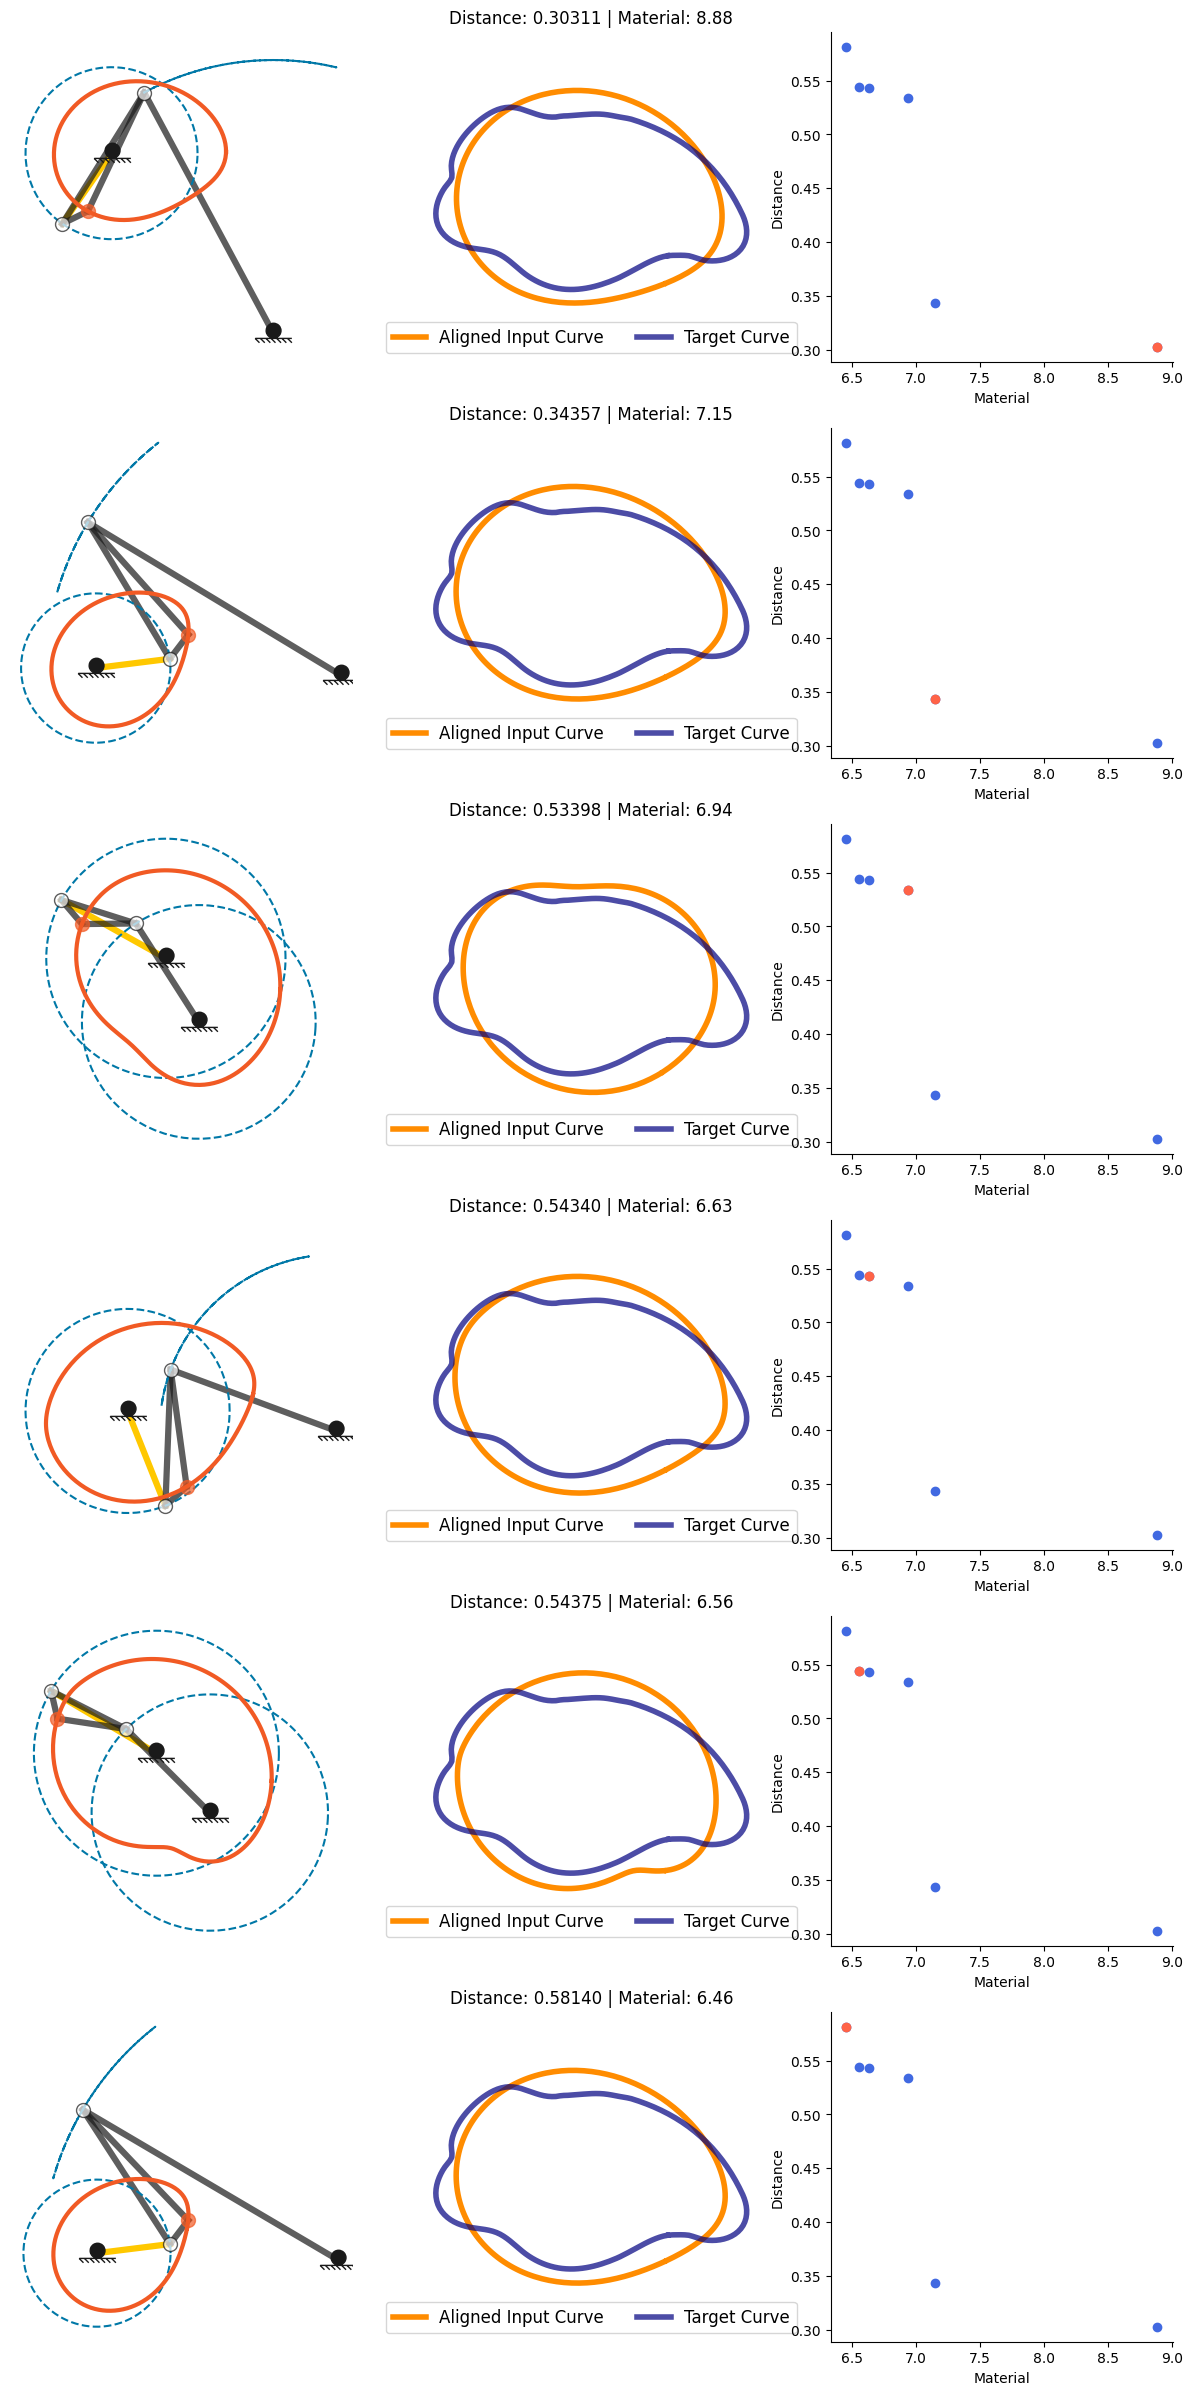

In [68]:
ga_visualizer.plot_pareto_efficient(
    F=results.F,
    population=submission['Problem 1'],
    target_curve=target_curves[1],
    objective_labels=['Distance', 'Material']
)